# Predictive Maintenance with Specialized GANs for Failure-Specific Oversampling

## Thesis Objective
This notebook is a core component of a thesis investigating advanced methods for handling class imbalance in predictive maintenance. The primary objective is to evaluate a specialized multi-GAN architecture against traditional sampling techniques. Instead of a single generative model for all failures, we train multiple Generative Adversarial Networks (GANs), where each GAN is an expert on a specific failure type (e.g., Overstrain, Power Failure). This approach is hypothesized to generate more realistic and useful synthetic data by capturing the unique data signatures of each failure mode.

We will compare the performance of Random Forest and SVM classifiers trained on data augmented by this specialized GAN approach against a baseline and standard methods like SMOTE and Random Undersampling.

The dataset used is the AI4I 2020 Predictive Maintenance Dataset, which is known for its severe class imbalance (3.4% failure rate) and its mixture of five distinct failure modes, including Heat Dissipation and Power Failure [1]. The generative model is based on the Conditional Tabular GAN (CTGAN) architecture, which utilizes mode-specific normalization and conditional generation to effectively model complex tabular data distributions [2]. [1]:"https://www.sciencedirect.com/science/article/pii/S2949863524000219". [2]:"https://www.researchgate.net/publication/344468956_Tabular_GANs_for_Uneven_Distribution".

## Notebook Structure
1.  Setup: Import libraries and provide environment setup guidance.
2.  GPU Check: Verify GPU availability for PyTorch, which accelerates TabGAN training.
3.  Load & Preprocess Data: Load, clean, and perform feature engineering on the predictive_maintenance.csv dataset.
4.  Exploratory Data Analysis (EDA): Analyze data characteristics, with a focus on the distinct signatures of different failure types.
5.  Data Splitting: Split data into Train, Validation, and Test sets to ensure robust evaluation and prevent data leakage.
6.  Modeling Scenarios:
    *   Scenario 1: Baseline (No Resampling)
    *   Scenario 2: Random Undersampling
    *   Scenario 3: SMOTE Oversampling
    *   Scenario 4: Specialized Multi-GAN Oversampling - This is the core of the new approach.
7.  Hyperparameter Tuning & Model Training:
    *   For the Multi-GAN scenario, a hyperparameter search is conducted to find the optimal GAN parameters, evaluating against the validation set.
    *   For all scenarios, GridSearchCV is used to tune the final classifiers (Random Forest & SVM).
8.  Evaluation: Assess all final models on the unseen test set using metrics appropriate for imbalanced data (F1, ROC-AUC, Recall, Precision).
9.  Results Comparison: Compile and visualize results to compare the effectiveness of each sampling strategy.
10. Conclusion: Discuss the findings, focusing on the performance of the specialized multi-GAN architecture.

## 1. Setup

This section imports necessary libraries and provides instructions for setting up the Python environment, including optional GPU acceleration via CUDA for TabGAN.

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
import time # To measure execution time
import logging # To manage library logging

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

# Imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
# Pipeline compatible with imblearn transformers
from imblearn.pipeline import Pipeline as ImbPipeline

# TabGAN (for GAN Oversampling)
try:
    from tabgan.sampler import GANGenerator
    import torch # TabGAN uses PyTorch
    GAN_AVAILABLE = True
    PYTORCH_AVAILABLE = True
except ImportError as e:
    print(f"Warning: TabGAN or PyTorch could not be imported. GAN scenario will be skipped. Error: {e}")
    print("Try installing with: pip install tabgan torch torchvision torchaudio")
    GANGenerator = None # Define as None if import fails
    GAN_AVAILABLE = False
    PYTORCH_AVAILABLE = False


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

print("Libraries imported.")
if PYTORCH_AVAILABLE:
    print(f"PyTorch Version: {torch.__version__}")
if GAN_AVAILABLE:
    print("TabGAN (for GAN Oversampling) is available.")
else:
    print("TabGAN could not be loaded. GAN scenario will be skipped.")

Libraries imported.
PyTorch Version: 2.5.1
TabGAN (for GAN Oversampling) is available.


## 2. GPU Check

This cell checks if a CUDA-enabled GPU is available for PyTorch (used by TabGAN).

In [2]:
gpu_available_for_tabgan = False
if PYTORCH_AVAILABLE:
    if torch.cuda.is_available():
        print(f"SUCCESS: PyTorch detected CUDA-enabled GPU: {torch.cuda.get_device_name(0)}")
        print("TabGAN will attempt to use the GPU if available.")
        gpu_available_for_tabgan = True
    else:
        print("INFO: PyTorch did not detect a CUDA-enabled GPU. TabGAN will run on CPU.")
else:
    print("INFO: PyTorch not available, cannot check for GPU for TabGAN.")

SUCCESS: PyTorch detected CUDA-enabled GPU: NVIDIA GeForce GTX 1060 with Max-Q Design
TabGAN will attempt to use the GPU if available.


## 3. Load & Preprocess Data

Load the dataset, perform feature engineering by converting temperature units and creating a difference feature, and sanitize column names.

**Rationale for Feature Engineering**

Two key feature engineering steps were performed based on insights from the AI4I 2020 dataset paper:

1. **Temperature Conversion (K to °C):** While models can process data on any scale, converting temperatures to Celsius enhances the interpretability of the Exploratory Data Analysis (EDA) and any subsequent model explanation steps.

2. **Creation of Temperature_difference_C:** The source paper explicitly notes that *Heat Dissipation Failure (HDF) occurs when the difference between process and air temperature is low while rotational speed is also low. By engineering this difference as a direct feature, we provide a more salient signal to our models, making it easier for them to learn and identify this specific failure condition.

In [3]:
# Load the dataset
try:
    df = pd.read_csv('predictive_maintenance.csv')
    print("Dataset loaded successfully.")
    print(f"Original dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: predictive_maintenance.csv not found. Please ensure the file is in the same directory as the notebook.")
    df = None

if df is not None:
    # Drop unnecessary columns
    df = df.drop(['UDI', 'Product ID'], axis=1)

    # 1. Convert temperatures from Kelvin to Celsius for better interpretability
    df['Air temperature [K]'] = df['Air temperature [K]'] - 273.15
    df['Process temperature [K]'] = df['Process temperature [K]'] - 273.15
    df.rename(columns={'Air temperature [K]': 'Air_temperature_C', 'Process temperature [K]': 'Process_temperature_C'}, inplace=True)
    print("\nConverted temperature units from Kelvin to Celsius.")

    # 2. Create the temperature difference feature
    df['Temperature_difference_C'] = df['Process_temperature_C'] - df['Air_temperature_C']
    print("Created 'Temperature_difference_C' feature.")

    # --- Data Cleaning: Sanitize All Column Names ---
    print("\nOriginal column names:\n", df.columns.tolist())
    clean_cols = {col: col.replace('[', '').replace(']', '').replace(' ', '').replace('(', '').replace(')', '') for col in df.columns}
    df.rename(columns=clean_cols, inplace=True)
    print("\nCleaned column names:\n", df.columns.tolist())

    # --- IMPORTANT: Update feature lists with new and cleaned names ---
    numerical_features = ['Air_temperature_C', 'Process_temperature_C', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Temperature_difference_C']
    categorical_features = ['Type']
    print("\nUpdated feature lists defined.")

    print("\nFirst 5 rows of the preprocessed dataset:")
    display(df.head())

    print("\nDataset Information after preprocessing:")
    df.info()

    print("\nDescriptive Statistics after preprocessing:")
    display(df.describe())

Dataset loaded successfully.
Original dataset shape: (10000, 10)

Converted temperature units from Kelvin to Celsius.
Created 'Temperature_difference_C' feature.

Original column names:
 ['Type', 'Air_temperature_C', 'Process_temperature_C', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type', 'Temperature_difference_C']

Cleaned column names:
 ['Type', 'Air_temperature_C', 'Process_temperature_C', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Target', 'FailureType', 'Temperature_difference_C']

Updated feature lists defined.

First 5 rows of the preprocessed dataset:


,Type,Air_temperature_C,Process_temperature_C,Rotationalspeedrpm,TorqueNm,Toolwearmin,Target,FailureType,Temperature_difference_C
0,M,24.95,35.45,1551,42.8,0,0,No Failure,10.5
1,L,25.05,35.55,1408,46.3,3,0,No Failure,10.5
2,L,24.95,35.35,1498,49.4,5,0,No Failure,10.4
3,L,25.05,35.45,1433,39.5,7,0,No Failure,10.4
4,L,25.05,35.55,1408,40.0,9,0,No Failure,10.5



Dataset Information after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      10000 non-null  object 
 1   Air_temperature_C         10000 non-null  float64
 2   Process_temperature_C     10000 non-null  float64
 3   Rotationalspeedrpm        10000 non-null  int64  
 4   TorqueNm                  10000 non-null  float64
 5   Toolwearmin               10000 non-null  int64  
 6   Target                    10000 non-null  int64  
 7   FailureType               10000 non-null  object 
 8   Temperature_difference_C  10000 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 703.2+ KB

Descriptive Statistics after preprocessing:


,Air_temperature_C,Process_temperature_C,Rotationalspeedrpm,TorqueNm,Toolwearmin,Target,Temperature_difference_C
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,26.854930,36.855560,1538.776100,39.986910,107.951000,0.033900,10.000630
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,1.001094
min,22.150000,32.550000,1168.000000,3.800000,0.000000,0.000000,7.600000
25%,25.150000,35.650000,1423.000000,33.200000,53.000000,0.000000,9.300000
50%,26.950000,36.950000,1503.000000,40.100000,108.000000,0.000000,9.800000
75%,28.350000,37.950000,1612.000000,46.800000,162.000000,0.000000,11.000000
max,31.350000,40.650000,2886.000000,76.600000,253.000000,1.000000,12.100000


## 4. Exploratory Data Analysis (EDA)

In this section, we conduct an Exploratory Data Analysis to achieve three primary goals:

1. **Quantify Class Imbalance:** To confirm the severity of the imbalance in both the overall target and within the specific failure types.

2. **Identify Predictive Features:** To visually inspect which features show different distributions for failure vs. non-failure cases.

3. **Justify the Multi-GAN Approach:** To analyze the feature distributions for each specific failure type (e.g., how does the *TorqueNm* distribution for 'Power Failure' differ from that of 'Overstrain Failure'?). This analysis is critical for validating the core hypothesis that each failure mode has a unique data signature.

### 4.1 Target Variable & Failure Type Analysis

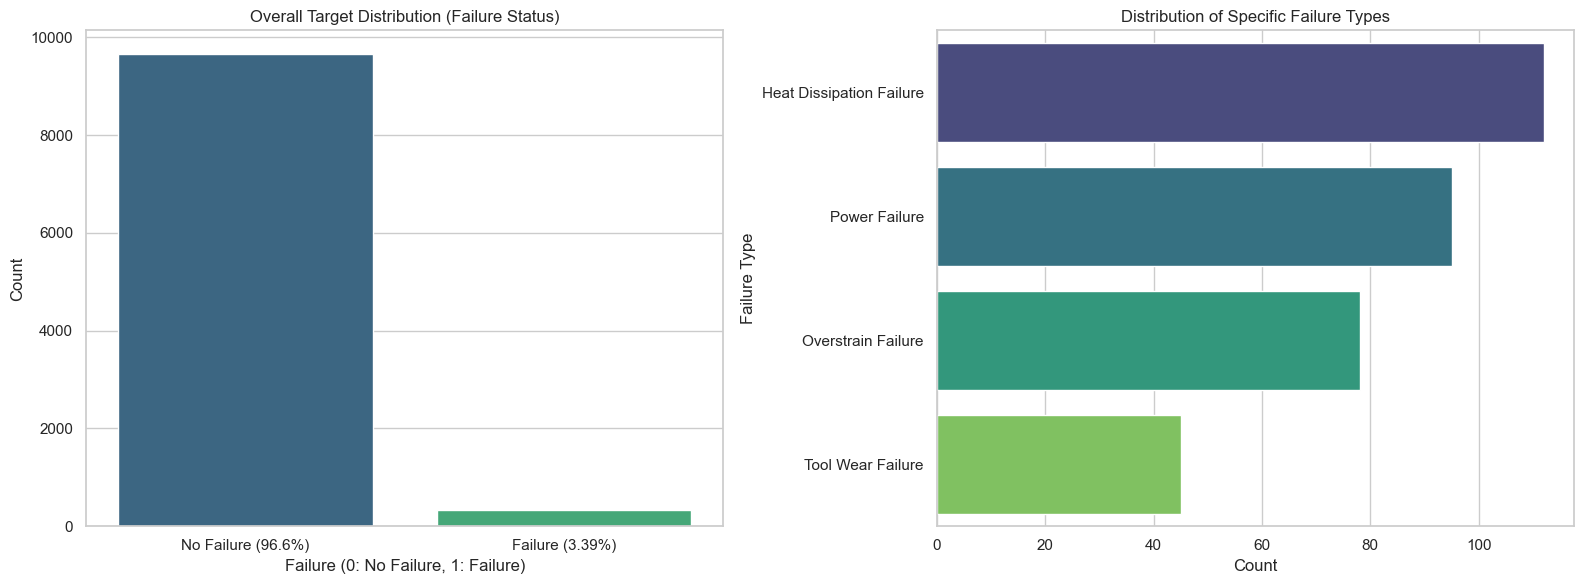

Failure Type Counts:
FailureType
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Name: count, dtype: int64


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall Target Distribution
target_counts = df['Target'].value_counts()
sns.countplot(x='Target', data=df, palette='viridis', ax=axes[0])
axes[0].set_title('Overall Target Distribution (Failure Status)')
axes[0].set_xlabel('Failure (0: No Failure, 1: Failure)')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1], ['No Failure (96.6%)', f'Failure ({target_counts[1]/len(df):.2%})'])

# Plot 2: Specific Failure Type Distribution
failure_df = df[df['Target'] == 1]
# Use the cleaned column name 'FailureType'
failure_type_counts = failure_df['FailureType'].value_counts()
failure_type_counts = failure_type_counts[failure_type_counts.index != 'No Failure']
# Use the cleaned column name 'FailureType' for the y-axis
sns.countplot(y='FailureType', data=failure_df[failure_df['FailureType'] != 'No Failure'], order=failure_type_counts.index, palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of Specific Failure Types')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Failure Type')

plt.tight_layout()
plt.show()

print("Failure Type Counts:")
print(failure_type_counts)

### 4.2 Feature Distributions and Relationships

Numerical Feature Distributions by Failure Status:


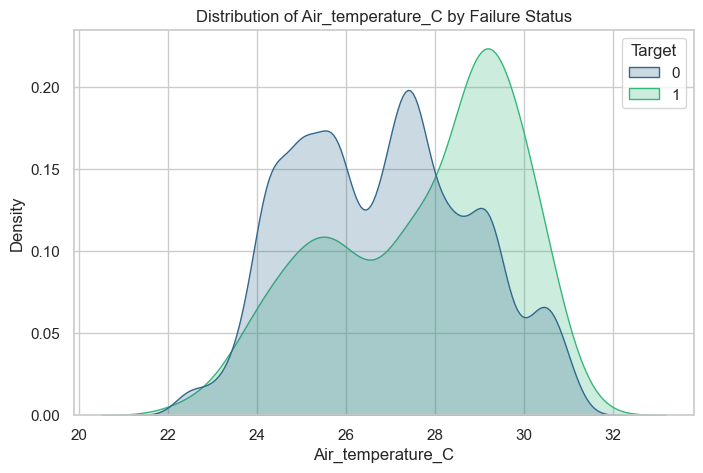

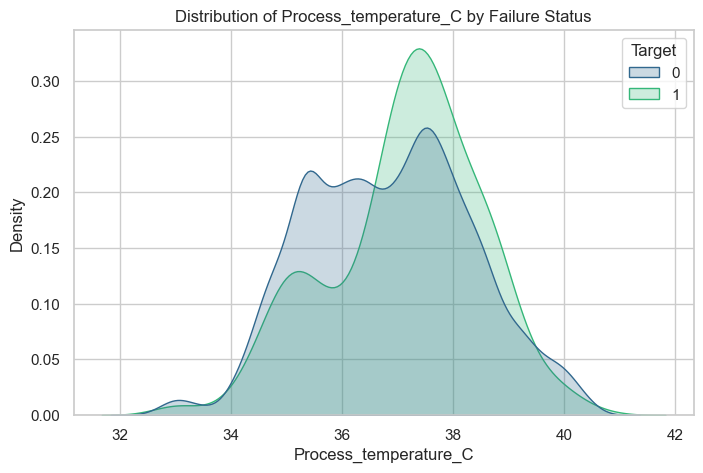

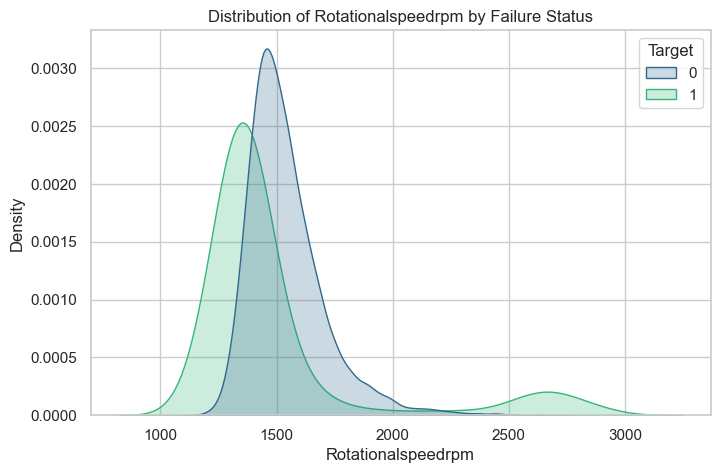

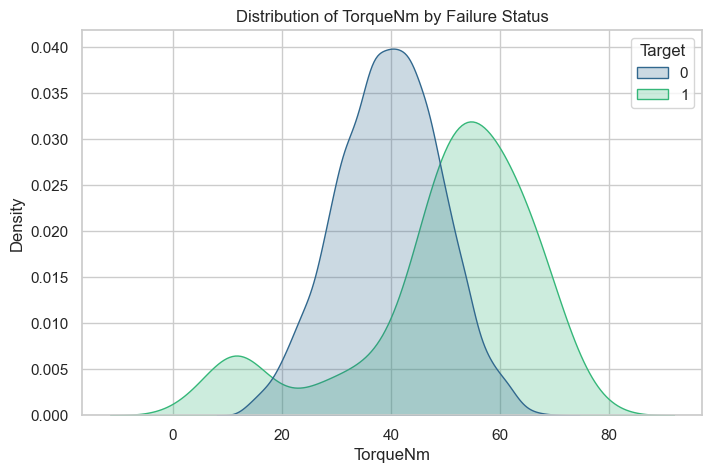

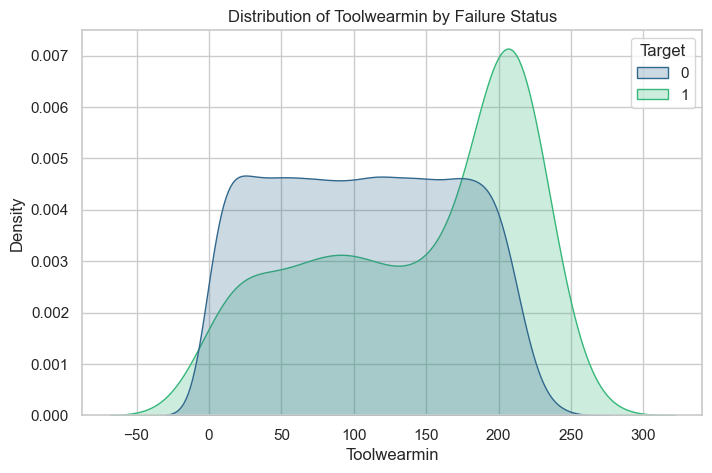

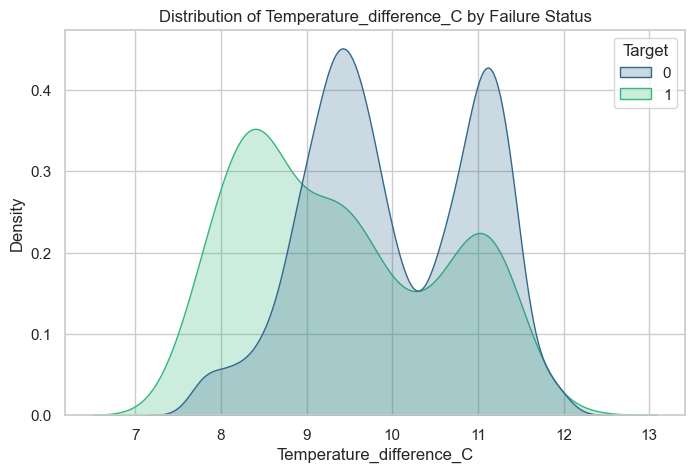

In [5]:
# Plot distributions grouped by Target variable
print("Numerical Feature Distributions by Failure Status:")
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=col, hue='Target', fill=True, common_norm=False, palette='viridis')
    plt.title(f'Distribution of {col} by Failure Status')
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(handles) == 2:
        plt.legend(handles, ['No Failure (0)', 'Failure (1)'], title='Failure Status')
    plt.show()

### 4.3 Correlation Analysis

Correlation Matrix:


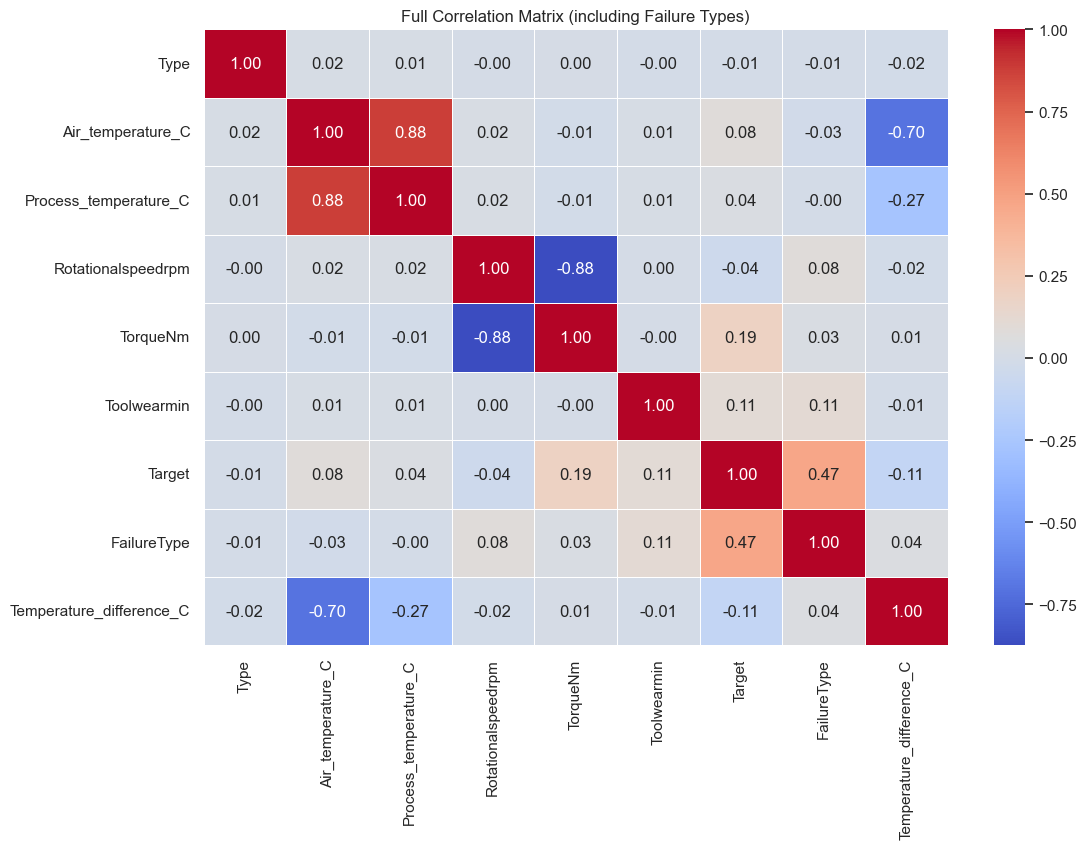

In [6]:
# Create a copy for correlation analysis
df_corr = df.copy()

# Convert categorical columns to numeric codes for correlation
df_corr['Type'] = df_corr['Type'].astype('category').cat.codes
# Use the cleaned column name 'FailureType'
df_corr['FailureType'] = df_corr['FailureType'].astype('category').cat.codes

print("Correlation Matrix:")
correlation_matrix = df_corr.corr() 

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Full Correlation Matrix (including Failure Types)')
plt.show()

## 5. Data Splitting & Final Preprocessing Setup

We will define the ColumnTransformer for consistent scaling and encoding. Crucially, we split the data into Training (70%), Validation (15%), and Test (15%) sets. The validation set is essential for tuning the GAN hyperparameters without leaking information from the final test set.

In [7]:
# Define features (X) and target (y)
# We keep 'Failure_Type' in X for now to identify subsets for GAN training
X = df.drop(['Target'], axis=1)
y = df['Target']

# --- Train-Validation-Test Split ---
# First split: 70% for training, 30% for a temporary set (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Split the 30% temp set into 15% validation and 15% test (50/50 split)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("--- Data Split Complete ---")
print(f"Training set shape: {X_train.shape}, Target distribution:\n{y_train.value_counts(normalize=True)}\n")
print(f"Validation set shape: {X_val.shape}, Target distribution:\n{y_val.value_counts(normalize=True)}\n")
print(f"Test set shape: {X_test.shape}, Target distribution:\n{y_test.value_counts(normalize=True)}\n")

# Now we can drop 'FailureType' from the feature sets used for classification
X_train_model = X_train.drop('FailureType', axis=1)
X_val_model = X_val.drop('FailureType', axis=1)
X_test_model = X_test.drop('FailureType', axis=1)

# Define the explicit order for the 'Type' column, which is our only categorical feature
type_order = ['L', 'M', 'H']

# Define the preprocessor using the final feature lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OrdinalEncoder(categories=[type_order]), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)(**not any**)
)

print("Preprocessor (ColumnTransformer) configured.")

--- Data Split Complete ---
Training set shape: (7000, 8), Target distribution:
Target
0    0.966143
1    0.033857
Name: proportion, dtype: float64

Validation set shape: (1500, 8), Target distribution:
Target
0    0.966
1    0.034
Name: proportion, dtype: float64

Test set shape: (1500, 8), Target distribution:
Target
0    0.966
1    0.034
Name: proportion, dtype: float64

Preprocessor (ColumnTransformer) configured.


## 6. Modeling Setup

Define models, hyperparameter grids, metrics, and the cross-validation strategy.

In [8]:
# Define Models
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
svm_model = SVC(random_state=42, probability=True, class_weight='balanced', cache_size=500)

# Define Hyperparameter Grids for final classifiers
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_leaf': [1, 3]
}

param_grid_svm = {
    'model__C': [1, 10],
    'model__gamma': ['scale', 0.1]
}

# Store results and best model info
results = {}
best_models_info = {}

# Define Stratified K-Fold for cross-validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Models, hyperparameter grids, and evaluation setup complete.")

Models, hyperparameter grids, and evaluation setup complete.


In [9]:
# Define the evaluation helper function
def evaluate_model(model_name, scenario_name, model, X_test_eval, y_test_eval, results_dict):
    """Calculates and stores evaluation metrics for a given model and test set."""
    print(f"--- Evaluating {model_name} ({scenario_name}) ---")
    start_time = time.time()
    y_pred = model.predict(X_test_eval)
    y_prob = model.predict_proba(X_test_eval)[:, 1]
    end_time = time.time()
    inference_time = end_time - start_time

    metrics = {
        'Accuracy': accuracy_score(y_test_eval, y_pred),
        'Precision': precision_score(y_test_eval, y_pred, zero_division=0),
        'Recall': recall_score(y_test_eval, y_pred),
        'F1': f1_score(y_test_eval, y_pred),
        'ROC_AUC': roc_auc_score(y_test_eval, y_prob)
    }

    if scenario_name not in results_dict:
        results_dict[scenario_name] = {}
    results_dict[scenario_name][model_name] = metrics

    print(f"Inference Time: {inference_time:.2f} seconds")
    print(classification_report(y_test_eval, y_pred, zero_division=0))
    print(f"ROC AUC Score: {metrics['ROC_AUC']:.4f}")
    print("-" * 60)

    # Plot Confusion Matrix and ROC Curve side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Evaluation for {model_name} ({scenario_name})', fontsize=16)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_eval, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues, ax=ax1)
    ax1.set_title('Confusion Matrix')
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_test_eval, y_prob, ax=ax2, name=model_name)
    ax2.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
    ax2.set_title('ROC Curve')
    ax2.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return metrics

## 7. Modeling Scenarios

We will now implement the four scenarios. Note: Resampling techniques are always applied only to the training data to prevent data leakage.

Across all scenarios, the underlying classifiers (*RandomForestClassifier* and *SVC*) are initialized with the "*class_weight='balanced'*" parameter. This setting automatically adjusts the weight of each sample in the model's loss function, giving more importance to samples from the under-represented minority class. This serves as a simple, built-in mechanism to mitigate imbalance and ensures that even our baseline model is not entirely naive to the class distribution problem.

### Scenario 1: Baseline (No Resampling)

--- Scenario 1: Baseline (No Resampling) ---

Training Random Forest (Baseline)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Evaluating Random Forest (Baseline) ---
Inference Time: 0.22 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1449
           1       0.88      0.73      0.80        51

    accuracy                           0.99      1500
   macro avg       0.94      0.86      0.89      1500
weighted avg       0.99      0.99      0.99      1500

ROC AUC Score: 0.9721
------------------------------------------------------------


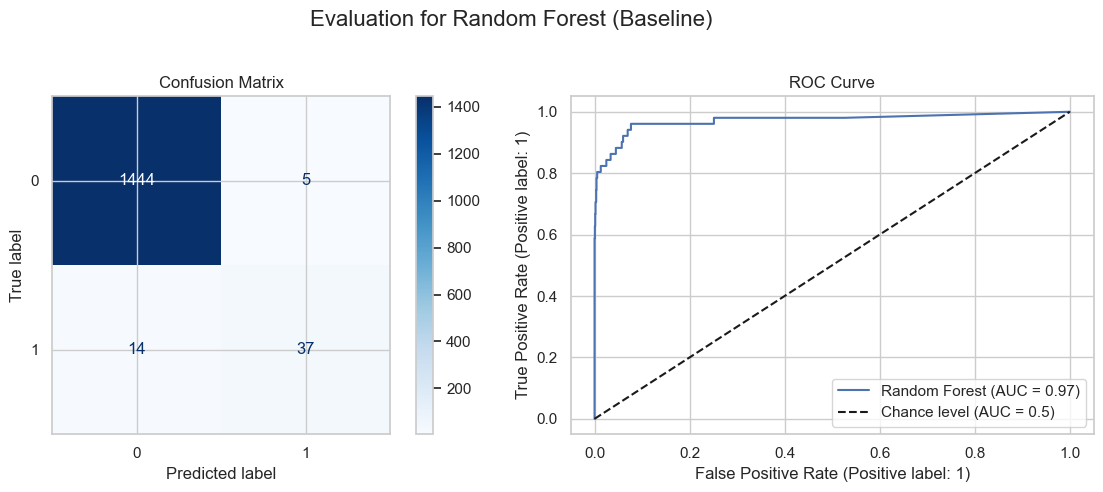


Training SVM (Baseline)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Evaluating SVM (Baseline) ---
Inference Time: 0.72 seconds
              precision    recall  f1-score   support

           0       1.00      0.92      0.95      1449
           1       0.28      0.94      0.43        51

    accuracy                           0.92      1500
   macro avg       0.64      0.93      0.69      1500
weighted avg       0.97      0.92      0.94      1500

ROC AUC Score: 0.9767
------------------------------------------------------------


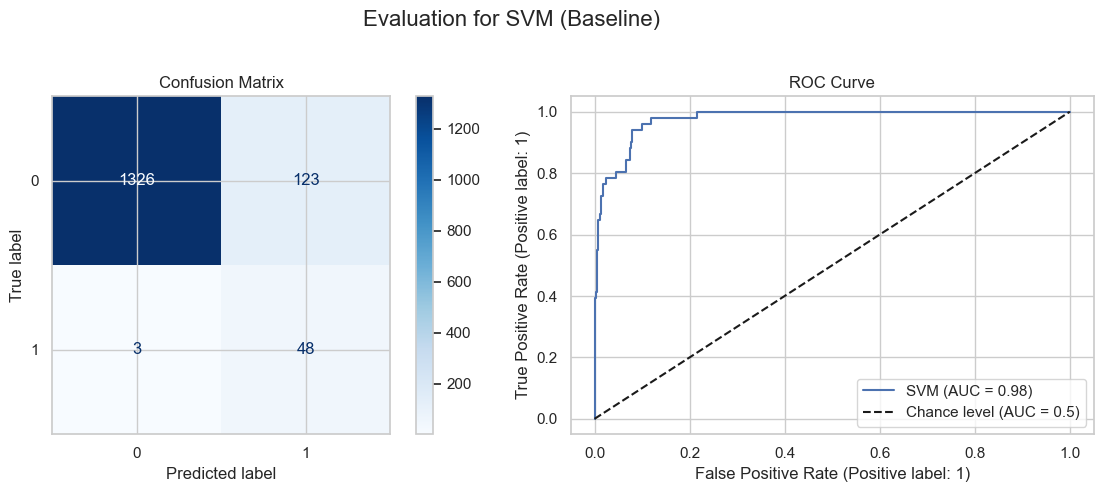

{'Accuracy': 0.916,
 'Precision': 0.2807017543859649,
 'Recall': 0.9411764705882353,
 'F1': 0.4324324324324324,
 'ROC_AUC': 0.976657329598506}

In [10]:
print("--- Scenario 1: Baseline (No Resampling) ---")
scenario = 'Baseline'
best_models_info[scenario] = {}

# --- Random Forest ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_base = Pipeline([('preprocessor', preprocessor), ('model', rf_model)])
grid_search_rf_base = GridSearchCV(pipeline_rf_base, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_base.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_base.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_base.best_estimator_, X_test_model, y_test, results)

# --- SVM ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_base = Pipeline([('preprocessor', preprocessor), ('model', svm_model)])
grid_search_svm_base = GridSearchCV(pipeline_svm_base, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_base.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_base.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_base.best_estimator_, X_test_model, y_test, results)

### Scenario 2: Random Undersampling (RUS)


--- Scenario 2: Random Undersampling (RUS) ---

Training Random Forest (Random Undersampling)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Evaluating Random Forest (Random Undersampling) ---
Inference Time: 0.15 seconds
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1449
           1       0.22      0.90      0.35        51

    accuracy                           0.89      1500
   macro avg       0.61      0.89      0.64      1500
weighted avg       0.97      0.89      0.92      1500

ROC AUC Score: 0.9685
------------------------------------------------------------


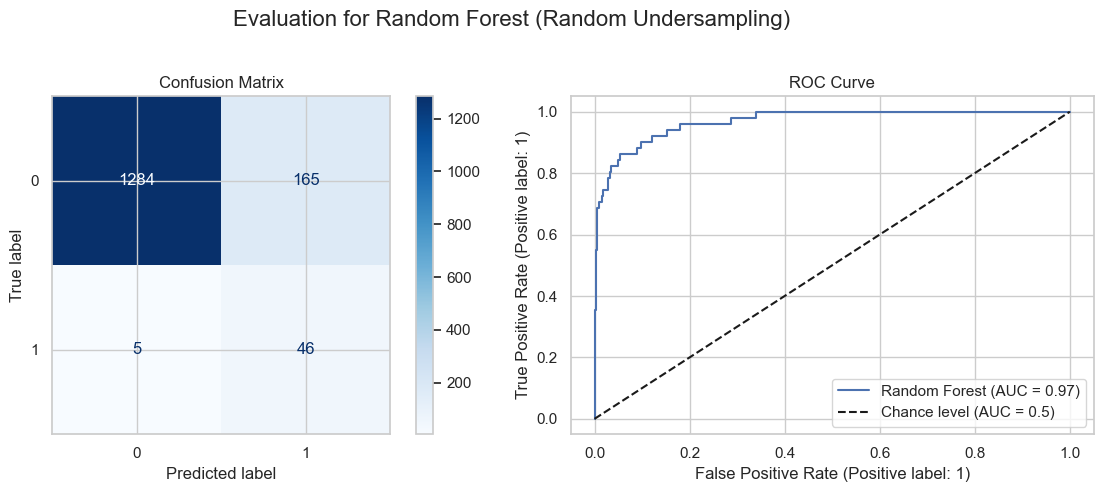


Training SVM (Random Undersampling)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Evaluating SVM (Random Undersampling) ---
Inference Time: 0.09 seconds
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1449
           1       0.23      0.90      0.36        51

    accuracy                           0.89      1500
   macro avg       0.61      0.90      0.65      1500
weighted avg       0.97      0.89      0.92      1500

ROC AUC Score: 0.9611
------------------------------------------------------------


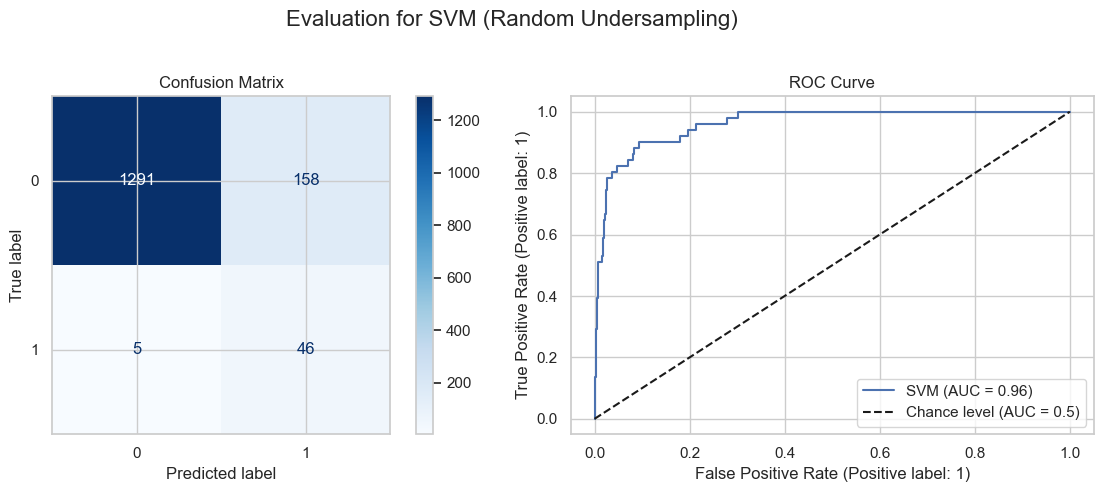

{'Accuracy': 0.8913333333333333,
 'Precision': 0.22549019607843138,
 'Recall': 0.9019607843137255,
 'F1': 0.3607843137254902,
 'ROC_AUC': 0.9610549533823192}

In [11]:
print("\n--- Scenario 2: Random Undersampling (RUS) ---")
scenario = 'Random Undersampling'
best_models_info[scenario] = {}
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# --- Random Forest with RUS ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_rus = ImbPipeline([('preprocessor', preprocessor), ('sampler', rus), ('model', rf_model)])
grid_search_rf_rus = GridSearchCV(pipeline_rf_rus, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_rus.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_rus.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_rus.best_estimator_, X_test_model, y_test, results)

# --- SVM with RUS ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_rus = ImbPipeline([('preprocessor', preprocessor), ('sampler', rus), ('model', svm_model)])
grid_search_svm_rus = GridSearchCV(pipeline_svm_rus, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_rus.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_rus.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_rus.best_estimator_, X_test_model, y_test, results)

### Scenario 3: SMOTE Oversampling


--- Scenario 3: SMOTE Oversampling ---

Training Random Forest (SMOTE Oversampling)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Evaluating Random Forest (SMOTE Oversampling) ---
Inference Time: 0.21 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1449
           1       0.52      0.73      0.61        51

    accuracy                           0.97      1500
   macro avg       0.76      0.85      0.79      1500
weighted avg       0.97      0.97      0.97      1500

ROC AUC Score: 0.9765
------------------------------------------------------------


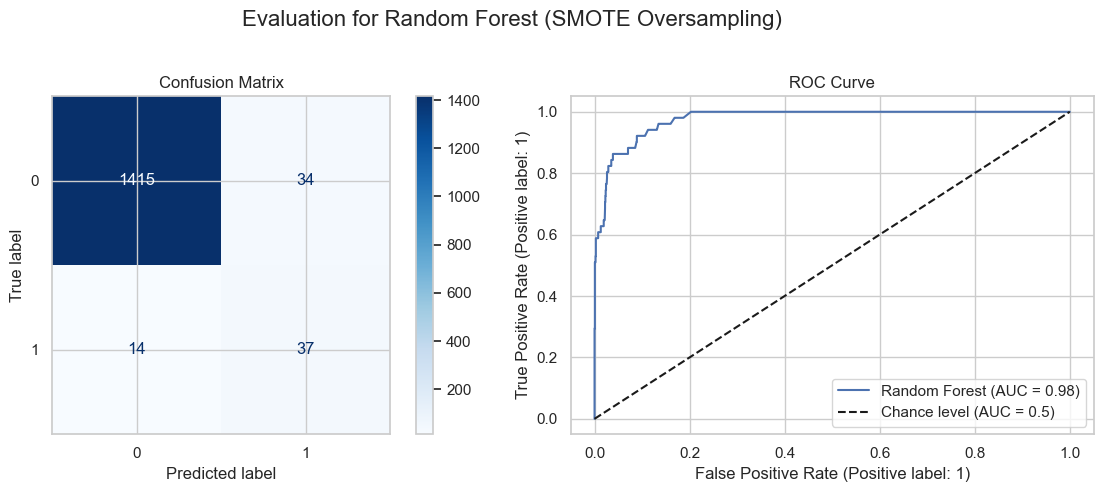


Training SVM (SMOTE Oversampling)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Evaluating SVM (SMOTE Oversampling) ---
Inference Time: 1.14 seconds
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1449
           1       0.27      0.86      0.41        51

    accuracy                           0.92      1500
   macro avg       0.63      0.89      0.68      1500
weighted avg       0.97      0.92      0.94      1500

ROC AUC Score: 0.9742
------------------------------------------------------------


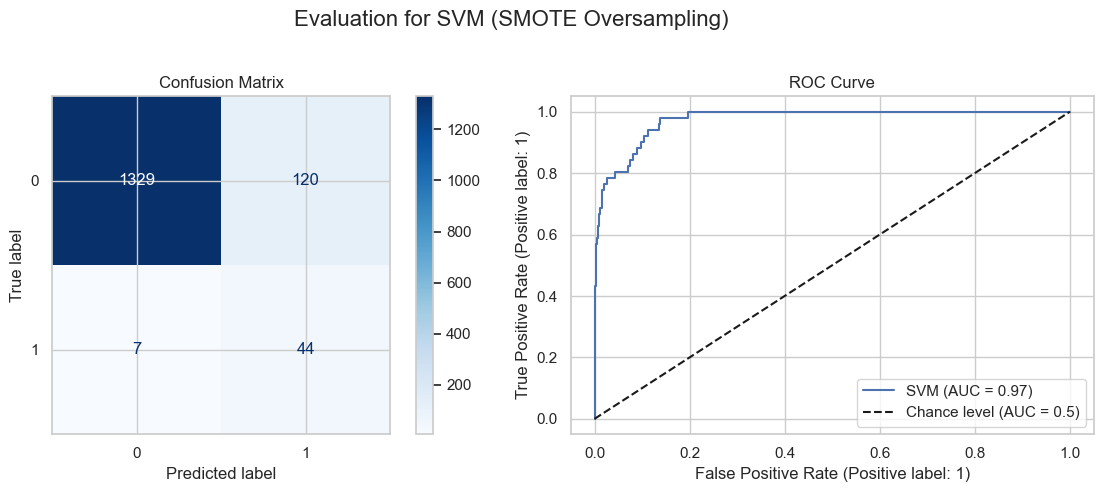

{'Accuracy': 0.9153333333333333,
 'Precision': 0.2682926829268293,
 'Recall': 0.8627450980392157,
 'F1': 0.4093023255813954,
 'ROC_AUC': 0.9741809767385214}

In [12]:
print("\n--- Scenario 3: SMOTE Oversampling ---")
scenario = 'SMOTE Oversampling'
best_models_info[scenario] = {}
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=-1)

# --- Random Forest with SMOTE ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_smote = ImbPipeline([('preprocessor', preprocessor), ('sampler', smote), ('model', rf_model)])
grid_search_rf_smote = GridSearchCV(pipeline_rf_smote, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_smote.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_smote.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_smote.best_estimator_, X_test_model, y_test, results)

# --- SVM with SMOTE ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_smote = ImbPipeline([('preprocessor', preprocessor), ('sampler', smote), ('model', svm_model)])
grid_search_svm_smote = GridSearchCV(pipeline_svm_smote, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_smote.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_smote.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_smote.best_estimator_, X_test_model, y_test, results)

### Scenario 4: Generalized Single-GAN Oversampling

This scenario implements the core hypothesis of the thesis. We train a separate GAN for each major failure type to learn its specific data signature. This involves a hyperparameter tuning loop to find the best GAN settings before training the final classifiers.

The tabgan library implements a variant of the Conditional Tabular GAN (CTGAN), which is particularly effective for tabular data. It uses a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** loss function, which is known to provide more stable training than traditional GANs. Furthermore, it incorporates an **adversarial filter** after generation; a secondary classifier (LightGBM) is trained to distinguish between the real and synthetic data, and only the highest-quality synthetic samples (those that fool the filter) are retained. Our multi-GAN approach leverages this powerful architecture by creating a dedicated, expert CTGAN for each failure mode.

The process is as follows:

1. **Hyperparameter Search:** Optuna is used to intelligently search for the optimal GAN and adversarial filter parameters.

2.  **Validation:** For each trial, a GAN is trained on all minority failure types simultaneously, data is generated, and a simple classifier is evaluated on the validation set to score the quality of the synthetic data.

3. **Final Model Training:** The best GAN parameters are used to generate a final augmented dataset, on which the full Random Forest and SVM grid searches are performed.


--- Scenario 4: Generalized Single-GAN Oversampling (TabGAN with Optuna) ---

Finding best RF parameters on original data to use for Optuna validation...
--> Found best RF params for Optuna loop: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

--- Optuna Trial #0 ---
--> Testing Params: {'gen_lr': 5.6115164153345e-05, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 1150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.039913058785616795}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #0: Validation ROC AUC = 0.9673 ---

--- Optuna Trial #1 ---
--> Testing Params: {'gen_lr': 0.0002607024758370766, 'discriminator_steps': 1, 'network_dim': 128, 'patience': 1400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 11, 'adv_learning_rate': 0.03347776308515933}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #1: Validation ROC AUC = 0.9530 ---

--- Optuna Trial #2 ---
--> Testing Params: {'gen_lr': 7.309539835912905e-05, 'discriminator_steps': 2, 'network_dim': 128, 'patience': 2400, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 18, 'adv_learning_rate': 0.015837031559118753}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #2: Validation ROC AUC = 0.9611 ---

--- Optuna Trial #3 ---
--> Testing Params: {'gen_lr': 0.00010677482709481354, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 650, 'batch_size': 750, 'adv_n_estimators': 600, 'adv_max_depth': 20, 'adv_learning_rate': 0.06432759992849894}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #3: Validation ROC AUC = 0.9525 ---

--- Optuna Trial #4 ---
--> Testing Params: {'gen_lr': 4.066563313514796e-05, 'discriminator_steps': 1, 'network_dim': 128, 'patience': 3150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.01814596135349025}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #4: Validation ROC AUC = 0.9527 ---

--- Optuna Trial #5 ---
--> Testing Params: {'gen_lr': 0.00021137059440645722, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 5900, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 20, 'adv_learning_rate': 0.07849235338159358}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #5: Validation ROC AUC = 0.9599 ---

--- Optuna Trial #6 ---
--> Testing Params: {'gen_lr': 0.0001569639638866114, 'discriminator_steps': 5, 'network_dim': 256, 'patience': 2150, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 11, 'adv_learning_rate': 0.0674120461070276}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #6: Validation ROC AUC = 0.9471 ---

--- Optuna Trial #7 ---
--> Testing Params: {'gen_lr': 5.170191786366994e-05, 'discriminator_steps': 2, 'network_dim': 512, 'patience': 650, 'batch_size': 750, 'adv_n_estimators': 600, 'adv_max_depth': 18, 'adv_learning_rate': 0.01580213186410389}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #7: Validation ROC AUC = 0.9505 ---

--- Optuna Trial #8 ---
--> Testing Params: {'gen_lr': 1.0257563974185649e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 650, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 9, 'adv_learning_rate': 0.07296312489711157}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #8: Validation ROC AUC = 0.9513 ---

--- Optuna Trial #9 ---
--> Testing Params: {'gen_lr': 0.00017643967683381525, 'discriminator_steps': 2, 'network_dim': 512, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 19, 'adv_learning_rate': 0.029662989987000676}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #9: Validation ROC AUC = 0.9598 ---

--- Optuna Trial #10 ---
--> Testing Params: {'gen_lr': 0.0009970682275036455, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 15, 'adv_learning_rate': 0.03888573699821314}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #10: Validation ROC AUC = 0.9683 ---

--- Optuna Trial #11 ---
--> Testing Params: {'gen_lr': 0.0009996235491574763, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 15, 'adv_learning_rate': 0.038950032285299}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #11: Validation ROC AUC = 0.9607 ---

--- Optuna Trial #12 ---
--> Testing Params: {'gen_lr': 0.0009986590540977272, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 15, 'adv_learning_rate': 0.04537273451618651}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #12: Validation ROC AUC = 0.9594 ---

--- Optuna Trial #13 ---
--> Testing Params: {'gen_lr': 2.258845611236793e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 3400, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 16, 'adv_learning_rate': 0.024144666480418336}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #13: Validation ROC AUC = 0.9514 ---

--- Optuna Trial #14 ---
--> Testing Params: {'gen_lr': 0.0004412958177163282, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 5650, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 13, 'adv_learning_rate': 0.010043055597541001}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #14: Validation ROC AUC = 0.9653 ---

--- Optuna Trial #15 ---
--> Testing Params: {'gen_lr': 2.5963101716497992e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 3400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.04981998780447283}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #15: Validation ROC AUC = 0.9526 ---

--- Optuna Trial #16 ---
--> Testing Params: {'gen_lr': 0.0004483062682639281, 'discriminator_steps': 3, 'network_dim': 128, 'patience': 5150, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 13, 'adv_learning_rate': 0.099503116997988}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #16: Validation ROC AUC = 0.9623 ---

--- Optuna Trial #17 ---
--> Testing Params: {'gen_lr': 0.00044866954817842833, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 1650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 8, 'adv_learning_rate': 0.02473178698781499}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #17: Validation ROC AUC = 0.9557 ---

--- Optuna Trial #18 ---
--> Testing Params: {'gen_lr': 9.545138089065657e-05, 'discriminator_steps': 4, 'network_dim': 256, 'patience': 2650, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 14, 'adv_learning_rate': 0.05139512618679786}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #18: Validation ROC AUC = 0.9503 ---

--- Optuna Trial #19 ---
--> Testing Params: {'gen_lr': 1.0020465738521187e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 17, 'adv_learning_rate': 0.037392559368518284}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #19: Validation ROC AUC = 0.9594 ---

--- Optuna Trial #20 ---
--> Testing Params: {'gen_lr': 2.161147785670996e-05, 'discriminator_steps': 3, 'network_dim': 128, 'patience': 1400, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 11, 'adv_learning_rate': 0.026603685744831112}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #20: Validation ROC AUC = 0.9552 ---

--- Optuna Trial #21 ---
--> Testing Params: {'gen_lr': 0.000559341314989958, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 5900, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 13, 'adv_learning_rate': 0.010055489435197903}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #21: Validation ROC AUC = 0.9594 ---

--- Optuna Trial #22 ---
--> Testing Params: {'gen_lr': 0.0006441339229722705, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 5150, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 13, 'adv_learning_rate': 0.01002871954968341}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #22: Validation ROC AUC = 0.9658 ---

--- Optuna Trial #23 ---
--> Testing Params: {'gen_lr': 0.0006842748148645661, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 5150, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 12, 'adv_learning_rate': 0.02022274012361769}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #23: Validation ROC AUC = 0.9636 ---

--- Optuna Trial #24 ---
--> Testing Params: {'gen_lr': 0.0003003480045014754, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 4900, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 15, 'adv_learning_rate': 0.012780350596466912}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #24: Validation ROC AUC = 0.9588 ---

--- Optuna Trial #25 ---
--> Testing Params: {'gen_lr': 0.000715958913046988, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 16, 'adv_learning_rate': 0.04218659371404653}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #25: Validation ROC AUC = 0.9581 ---

--- Optuna Trial #26 ---
--> Testing Params: {'gen_lr': 0.0003229807775656782, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 10, 'adv_learning_rate': 0.056446748545862985}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #26: Validation ROC AUC = 0.9611 ---

--- Optuna Trial #27 ---
--> Testing Params: {'gen_lr': 0.00012610763806447382, 'discriminator_steps': 3, 'network_dim': 128, 'patience': 4900, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 14, 'adv_learning_rate': 0.032586660220451286}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #27: Validation ROC AUC = 0.9574 ---

--- Optuna Trial #28 ---
--> Testing Params: {'gen_lr': 6.26702682649954e-05, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 5400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 12, 'adv_learning_rate': 0.021269587253342093}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #28: Validation ROC AUC = 0.9507 ---

--- Optuna Trial #29 ---
--> Testing Params: {'gen_lr': 3.513594563147293e-05, 'discriminator_steps': 5, 'network_dim': 256, 'patience': 1900, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 16, 'adv_learning_rate': 0.0346402126603693}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #29: Validation ROC AUC = 0.9315 ---

--- Optuna Trial #30 ---
--> Testing Params: {'gen_lr': 0.0002443525024065972, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 2650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 12, 'adv_learning_rate': 0.02935983589035441}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #30: Validation ROC AUC = 0.9514 ---

--- Optuna Trial #31 ---
--> Testing Params: {'gen_lr': 0.00040183497714406857, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 5650, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 13, 'adv_learning_rate': 0.010009706750964027}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #31: Validation ROC AUC = 0.9633 ---

--- Optuna Trial #32 ---
--> Testing Params: {'gen_lr': 0.0007142558294753706, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 14, 'adv_learning_rate': 0.01235661057620763}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #32: Validation ROC AUC = 0.9612 ---

--- Optuna Trial #33 ---
--> Testing Params: {'gen_lr': 0.0005767424912249249, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 5400, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 10, 'adv_learning_rate': 0.01240295391535022}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #33: Validation ROC AUC = 0.9546 ---

--- Optuna Trial #34 ---
--> Testing Params: {'gen_lr': 8.237619632719311e-05, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 1150, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 13, 'adv_learning_rate': 0.014904314151185961}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #34: Validation ROC AUC = 0.9628 ---

--- Optuna Trial #35 ---
--> Testing Params: {'gen_lr': 0.0008441506095311296, 'discriminator_steps': 1, 'network_dim': 128, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 18, 'adv_learning_rate': 0.011272998738594772}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #35: Validation ROC AUC = 0.9693 ---

--- Optuna Trial #36 ---
--> Testing Params: {'gen_lr': 0.0008492797731166791, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3650, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 19, 'adv_learning_rate': 0.013944342144459977}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #36: Validation ROC AUC = 0.9587 ---

--- Optuna Trial #37 ---
--> Testing Params: {'gen_lr': 0.0005757065315757259, 'discriminator_steps': 1, 'network_dim': 128, 'patience': 2900, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 20, 'adv_learning_rate': 0.017846446899322736}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #37: Validation ROC AUC = 0.9429 ---

--- Optuna Trial #38 ---
--> Testing Params: {'gen_lr': 4.703168172176273e-05, 'discriminator_steps': 3, 'network_dim': 128, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.05931635726880353}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #38: Validation ROC AUC = 0.9684 ---

--- Optuna Trial #39 ---
--> Testing Params: {'gen_lr': 4.5436113290488756e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.05993624224151562}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #39: Validation ROC AUC = 0.9698 ---

--- Optuna Trial #40 ---
--> Testing Params: {'gen_lr': 4.5149530132194725e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.08605242103510155}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #40: Validation ROC AUC = 0.9692 ---

--- Optuna Trial #41 ---
--> Testing Params: {'gen_lr': 4.4914909309620355e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.08716733726304435}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #41: Validation ROC AUC = 0.9668 ---

--- Optuna Trial #42 ---
--> Testing Params: {'gen_lr': 3.237402004495313e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.061265165057088476}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #42: Validation ROC AUC = 0.9728 ---

--- Optuna Trial #43 ---
--> Testing Params: {'gen_lr': 3.226079686404829e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.06175817370085657}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #43: Validation ROC AUC = 0.9501 ---

--- Optuna Trial #44 ---
--> Testing Params: {'gen_lr': 1.5469727483790107e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.07827778359252327}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #44: Validation ROC AUC = 0.9601 ---

--- Optuna Trial #45 ---
--> Testing Params: {'gen_lr': 5.9162477336745495e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.06836189796588678}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #45: Validation ROC AUC = 0.9697 ---

--- Optuna Trial #46 ---
--> Testing Params: {'gen_lr': 6.221131684810997e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.06936714682429605}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #46: Validation ROC AUC = 0.9569 ---

--- Optuna Trial #47 ---
--> Testing Params: {'gen_lr': 3.6438234261397084e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.08947878534507014}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #47: Validation ROC AUC = 0.9542 ---

--- Optuna Trial #48 ---
--> Testing Params: {'gen_lr': 7.483866508855429e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.07569922112108673}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #48: Validation ROC AUC = 0.9605 ---

--- Optuna Trial #49 ---
--> Testing Params: {'gen_lr': 2.826130896105029e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.08637288469439862}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #49: Validation ROC AUC = 0.9588 ---

--- Optuna Trial #50 ---
--> Testing Params: {'gen_lr': 1.720932971287851e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 3650, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 18, 'adv_learning_rate': 0.05346212710087636}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #50: Validation ROC AUC = 0.9593 ---

--- Optuna Trial #51 ---
--> Testing Params: {'gen_lr': 4.870334483503421e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.0612914127185773}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #51: Validation ROC AUC = 0.9695 ---

--- Optuna Trial #52 ---
--> Testing Params: {'gen_lr': 5.5025337018742445e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.06594079914163688}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #52: Validation ROC AUC = 0.9687 ---

--- Optuna Trial #53 ---
--> Testing Params: {'gen_lr': 0.0001208277463397813, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.04667199101564032}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #53: Validation ROC AUC = 0.9608 ---

--- Optuna Trial #54 ---
--> Testing Params: {'gen_lr': 4.114339979588325e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.09995949707935206}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #54: Validation ROC AUC = 0.9619 ---

--- Optuna Trial #55 ---
--> Testing Params: {'gen_lr': 9.089974100984445e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.07081122419301313}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #55: Validation ROC AUC = 0.9502 ---

--- Optuna Trial #56 ---
--> Testing Params: {'gen_lr': 6.55016483002923e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 17, 'adv_learning_rate': 0.06325690225005787}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #56: Validation ROC AUC = 0.9703 ---

--- Optuna Trial #57 ---
--> Testing Params: {'gen_lr': 6.576031393862384e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4900, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 17, 'adv_learning_rate': 0.05664890005723178}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #57: Validation ROC AUC = 0.9570 ---

--- Optuna Trial #58 ---
--> Testing Params: {'gen_lr': 0.0001636504432198276, 'discriminator_steps': 1, 'network_dim': 512, 'patience': 400, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 19, 'adv_learning_rate': 0.0474337873448644}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #58: Validation ROC AUC = 0.9456 ---

--- Optuna Trial #59 ---
--> Testing Params: {'gen_lr': 5.3016698287565176e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 3650, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 19, 'adv_learning_rate': 0.04256675151220947}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #59: Validation ROC AUC = 0.9594 ---

--- Optuna Trial #60 ---
--> Testing Params: {'gen_lr': 0.00011024101802120695, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 600, 'adv_max_depth': 16, 'adv_learning_rate': 0.06386585422197377}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #60: Validation ROC AUC = 0.9633 ---

--- Optuna Trial #61 ---
--> Testing Params: {'gen_lr': 2.9223564588575996e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.08223487368323107}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #61: Validation ROC AUC = 0.9668 ---

--- Optuna Trial #62 ---
--> Testing Params: {'gen_lr': 2.3167898482220004e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.07318678296751943}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #62: Validation ROC AUC = 0.9594 ---

--- Optuna Trial #63 ---
--> Testing Params: {'gen_lr': 3.978111552787176e-05, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.05350332645818806}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #63: Validation ROC AUC = 0.9607 ---

--- Optuna Trial #64 ---
--> Testing Params: {'gen_lr': 4.7932026193059035e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 3400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.0927877800231617}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #64: Validation ROC AUC = 0.9468 ---

--- Optuna Trial #65 ---
--> Testing Params: {'gen_lr': 7.284726897663335e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 19, 'adv_learning_rate': 0.0598716326820981}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #65: Validation ROC AUC = 0.9625 ---

--- Optuna Trial #66 ---
--> Testing Params: {'gen_lr': 1.861250073380281e-05, 'discriminator_steps': 2, 'network_dim': 512, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.0808803335741838}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #66: Validation ROC AUC = 0.9596 ---

--- Optuna Trial #67 ---
--> Testing Params: {'gen_lr': 0.0001398755415959622, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.06692579968196649}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #67: Validation ROC AUC = 0.9704 ---

--- Optuna Trial #68 ---
--> Testing Params: {'gen_lr': 0.00019768199812517055, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4900, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 16, 'adv_learning_rate': 0.06671160903753318}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #68: Validation ROC AUC = 0.9595 ---

--- Optuna Trial #69 ---
--> Testing Params: {'gen_lr': 0.00014056875324259144, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 17, 'adv_learning_rate': 0.05003167863859727}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #69: Validation ROC AUC = 0.9606 ---

--- Optuna Trial #70 ---
--> Testing Params: {'gen_lr': 1.2815816298970728e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 16, 'adv_learning_rate': 0.0564767758760113}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #70: Validation ROC AUC = 0.9599 ---

--- Optuna Trial #71 ---
--> Testing Params: {'gen_lr': 5.9024604292068536e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.07347347894128844}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #71: Validation ROC AUC = 0.9697 ---

--- Optuna Trial #72 ---
--> Testing Params: {'gen_lr': 5.9436331503525976e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.0731146632129274}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #72: Validation ROC AUC = 0.9619 ---

--- Optuna Trial #73 ---
--> Testing Params: {'gen_lr': 8.518690480409e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.06320408730786183}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #73: Validation ROC AUC = 0.9582 ---

--- Optuna Trial #74 ---
--> Testing Params: {'gen_lr': 7.15443359650028e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 16, 'adv_learning_rate': 0.06837610878892321}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #74: Validation ROC AUC = 0.9681 ---

--- Optuna Trial #75 ---
--> Testing Params: {'gen_lr': 0.00010262704713160601, 'discriminator_steps': 1, 'network_dim': 512, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.05908439541899465}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #75: Validation ROC AUC = 0.9682 ---

--- Optuna Trial #76 ---
--> Testing Params: {'gen_lr': 3.327205890963921e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3400, 'batch_size': 750, 'adv_n_estimators': 300, 'adv_max_depth': 20, 'adv_learning_rate': 0.035994054238789853}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #76: Validation ROC AUC = 0.9518 ---

--- Optuna Trial #77 ---
--> Testing Params: {'gen_lr': 3.9520110148065413e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 15, 'adv_learning_rate': 0.04322410941102499}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #77: Validation ROC AUC = 0.9605 ---

--- Optuna Trial #78 ---
--> Testing Params: {'gen_lr': 5.1950319759724045e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.052997383740477924}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #78: Validation ROC AUC = 0.9633 ---

--- Optuna Trial #79 ---
--> Testing Params: {'gen_lr': 2.5317679243780506e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.011097036896933697}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #79: Validation ROC AUC = 0.9635 ---

--- Optuna Trial #80 ---
--> Testing Params: {'gen_lr': 7.990107907451566e-05, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 5150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.07690566728423535}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #80: Validation ROC AUC = 0.9623 ---

--- Optuna Trial #81 ---
--> Testing Params: {'gen_lr': 4.458028739208165e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.09361313877673166}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #81: Validation ROC AUC = 0.9693 ---

--- Optuna Trial #82 ---
--> Testing Params: {'gen_lr': 6.632586312134807e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 3650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.09388580375619417}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #82: Validation ROC AUC = 0.9606 ---

--- Optuna Trial #83 ---
--> Testing Params: {'gen_lr': 5.713498216623297e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.08213069963785502}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #83: Validation ROC AUC = 0.9689 ---

--- Optuna Trial #84 ---
--> Testing Params: {'gen_lr': 3.0471019647449957e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.06471219855559004}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #84: Validation ROC AUC = 0.9612 ---

--- Optuna Trial #85 ---
--> Testing Params: {'gen_lr': 3.657625176126263e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.0302716585012344}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #85: Validation ROC AUC = 0.9709 ---

--- Optuna Trial #86 ---
--> Testing Params: {'gen_lr': 3.6546820533136796e-05, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 15, 'adv_learning_rate': 0.030213313550962358}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #86: Validation ROC AUC = 0.9583 ---

--- Optuna Trial #87 ---
--> Testing Params: {'gen_lr': 4.3257308336882654e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.026752979888497497}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #87: Validation ROC AUC = 0.9588 ---

--- Optuna Trial #88 ---
--> Testing Params: {'gen_lr': 4.9088490276823664e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 16, 'adv_learning_rate': 0.07089311176383027}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #88: Validation ROC AUC = 0.9562 ---

--- Optuna Trial #89 ---
--> Testing Params: {'gen_lr': 2.6434088303275273e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.03972847480545977}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #89: Validation ROC AUC = 0.9640 ---

--- Optuna Trial #90 ---
--> Testing Params: {'gen_lr': 3.69068357903653e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.061082953443755895}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #90: Validation ROC AUC = 0.9729 ---

--- Optuna Trial #91 ---
--> Testing Params: {'gen_lr': 3.6957590370474396e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.06096632171876617}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #91: Validation ROC AUC = 0.9684 ---

--- Optuna Trial #92 ---
--> Testing Params: {'gen_lr': 3.272847778583653e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.056627410020270705}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #92: Validation ROC AUC = 0.9580 ---

--- Optuna Trial #93 ---
--> Testing Params: {'gen_lr': 4.3364004387715994e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.07508851172047769}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #93: Validation ROC AUC = 0.9589 ---

--- Optuna Trial #94 ---
--> Testing Params: {'gen_lr': 5.6321316239889606e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.06775355026109893}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #94: Validation ROC AUC = 0.9693 ---

--- Optuna Trial #95 ---
--> Testing Params: {'gen_lr': 4.990335023747393e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.04852506044726487}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #95: Validation ROC AUC = 0.9613 ---

--- Optuna Trial #96 ---
--> Testing Params: {'gen_lr': 6.684938001740274e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 17, 'adv_learning_rate': 0.02751418432375734}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #96: Validation ROC AUC = 0.9581 ---

--- Optuna Trial #97 ---
--> Testing Params: {'gen_lr': 9.258447425740262e-05, 'discriminator_steps': 2, 'network_dim': 512, 'patience': 2900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 8, 'adv_learning_rate': 0.023620029176879283}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #97: Validation ROC AUC = 0.9399 ---

--- Optuna Trial #98 ---
--> Testing Params: {'gen_lr': 2.0681677835958472e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 3650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.033323065379130296}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #98: Validation ROC AUC = 0.9597 ---

--- Optuna Trial #99 ---
--> Testing Params: {'gen_lr': 3.9291015226483506e-05, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 18, 'adv_learning_rate': 0.0517158737229842}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #99: Validation ROC AUC = 0.9688 ---

========================= Optuna HPO Complete =========================
Best Validation ROC AUC found: 0.9729
Best Hyperparameters: {'gen_lr': 3.69068357903653e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4150, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.061082953443755895}

Generating final augmented dataset with best GAN parameters...


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Final augmented training set shape: (16428, 7)
Final training set balance:
1    0.588325
0    0.411675
Name: proportion, dtype: float64

Training Random Forest on data from best GAN...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Evaluating Random Forest (GAN Oversampling (Single Model)) ---
Inference Time: 0.22 seconds
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1449
           1       0.28      0.90      0.42        51

    accuracy                           0.92      1500
   macro avg       0.64      0.91      0.69      1500
weighted avg       0.97      0.92      0.94      1500

ROC AUC Score: 0.9682
------------------------------------------------------------


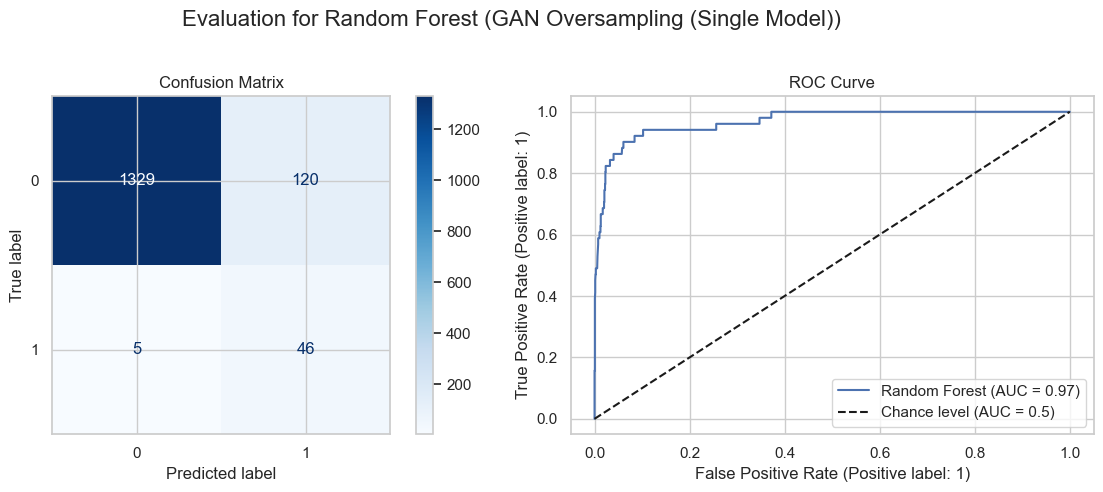


Training  SVM on data from best GAN...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Evaluating SVM (GAN Oversampling (Single Model)) ---
Inference Time: 1.17 seconds
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1449
           1       0.44      0.86      0.59        51

    accuracy                           0.96      1500
   macro avg       0.72      0.91      0.78      1500
weighted avg       0.98      0.96      0.96      1500

ROC AUC Score: 0.9567
------------------------------------------------------------


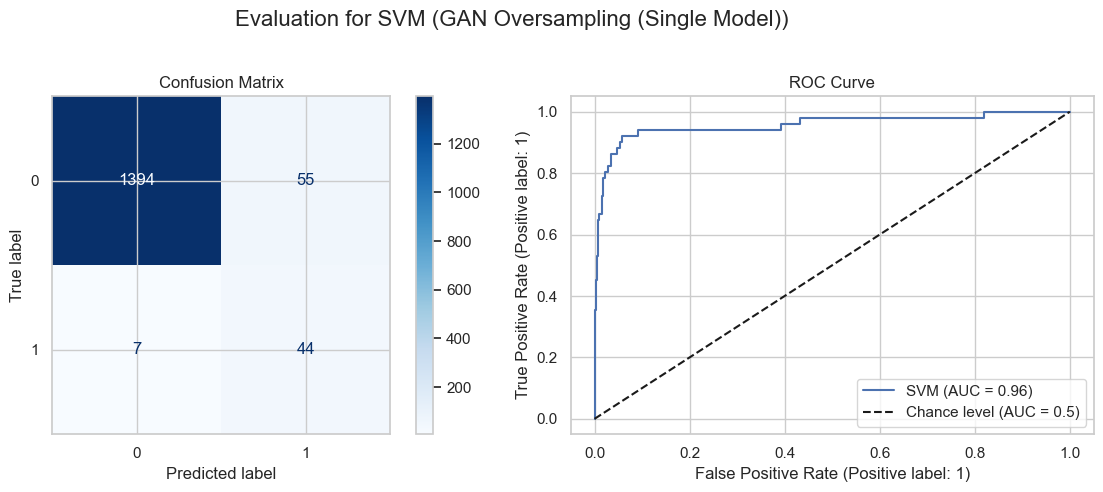

In [13]:
# =====================================================================================
# --- Scenario 4: Generalized Single-GAN Oversampling with Optuna HPO ---
# =====================================================================================
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Warning: Optuna could not be imported. The advanced GAN HPO scenario will not run.")
    print("Try installing with: pip install optuna")
    OPTUNA_AVAILABLE = False


# UPDATED: Title reflects the new single-GAN approach
print("\n--- Scenario 4: Generalized Single-GAN Oversampling (TabGAN with Optuna) ---")
# UPDATED: Scenario name for results table
scenario = 'GAN Oversampling (Single Model)'
best_models_info[scenario] = {}

# Suppress verbose LightGBM warnings from tabgan's adversarial filter and Optuna's trial logs
logging.getLogger('lightgbm').setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.WARNING)


if not GAN_AVAILABLE or not PYTORCH_AVAILABLE or not OPTUNA_AVAILABLE:
    print(f"{scenario} skipped: TabGAN/PyTorch/Optuna not available.")
    # Define a placeholder for metrics to prevent errors in the results summary
    metrics_dict_keys = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    results[scenario] = {
        'Random Forest': {m: np.nan for m in metrics_dict_keys},
        'SVM': {m: np.nan for m in metrics_dict_keys}
    }
else:
    # ===================================================================
    # --- PRE-OPTUNA STEP: FIND BEST RF PARAMETERS ON ORIGINAL DATA ---
    # To make the Optuna evaluation model more robust and closer to the final
    # model, we first find the best RF hyperparameters on the original,
    # non-augmented data. These parameters will be used inside every Optuna trial.
    print("\nFinding best RF parameters on original data to use for Optuna validation...")

    # We need a temporary pipeline for this one-off grid search
    temp_rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', rf_model)
    ])

    # Perform the grid search on the original training data
    gs_for_optuna_model = GridSearchCV(
        temp_rf_pipeline,
        param_grid_rf,
        cv=cv_stratified,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0 # Keep the output clean
    )
    
    gs_for_optuna_model.fit(X_train_model, y_train)

    # Now, we extract just the 'model' step from the best pipeline.
    # This gives us a pre-configured, tuned RandomForestClassifier instance.
    tuned_rf_for_optuna = gs_for_optuna_model.best_estimator_.named_steps['model']
    
    print(f"--> Found best RF params for Optuna loop: {tuned_rf_for_optuna.get_params()}")
    # ===================================================================

    # --- 1. Define the Objective Function for Optuna ---
    def objective(trial):
        """
        An objective function for Optuna to maximize. It trains a single generalized GAN
        with a given set of hyperparameters and evaluates it on the validation set.
        """
        # --- Define Hyperparameter Search Space using Optuna's trial object ---
        # These ranges are based on the provided research papers and best practices.
        
        # A. Generator/Discriminator Network Parameters
        gen_lr = trial.suggest_float("gen_lr", 1e-5, 1e-3, log=True) # Learning rate for GAN networks
        discriminator_steps = trial.suggest_int("discriminator_steps", 1, 5) # Number of times to train discriminator per generator step
        network_dim = trial.suggest_categorical("network_dim", [128, 256, 512]) # Width of hidden layers in networks
        
        # B. Training Parameters
        patience = trial.suggest_int("patience", 400, 6000, step=250) # Early stopping patience
        batch_size = trial.suggest_categorical("batch_size", [750]) # Batch size for training GAN

        # C. Adversarial Filter (LightGBM) Parameters
        adv_n_estimators = trial.suggest_int("adv_n_estimators", 200, 600, step=100) # Number of trees for the quality filter
        adv_max_depth = trial.suggest_int("adv_max_depth", 8, 20) # Max depth for filter trees
        adv_learning_rate = trial.suggest_float("adv_learning_rate", 0.01, 0.1, log=True) # Learning rate for filter
        
        # --- Construct Parameter Dictionaries for TabGAN ---
        current_gen_params = {
            'epochs': 8000,  # A sufficiently high number for early stopping to trigger
            'patience': patience,
            'batch_size': batch_size,
            'generator_lr': gen_lr,
            'discriminator_lr': gen_lr,
            'discriminator_steps': discriminator_steps,
            'generator_dim': (network_dim, network_dim),
            'discriminator_dim': (network_dim, network_dim),
            'seed': 42
        }
        current_adv_params = {
            'n_estimators': adv_n_estimators,
            'max_depth': adv_max_depth,
            'learning_rate': adv_learning_rate,
            'num_leaves': int(2**(adv_max_depth * 0.7)), # Heuristic for num_leaves
            'random_state': 42,
            'verbose': -1
        }

        print(f"\n--- Optuna Trial #{trial.number} ---")
        print(f"--> Testing Params: {trial.params}")

        try:
            # --- MODIFIED: Train a single GAN on all failure types ---
            # 1. Get all minority class (failure) samples from the training set
            X_train_failures = X_train[y_train == 1]
            
            # Check if there are enough failure samples to train
            if len(X_train_failures) < 10: # CTGAN requires batch_size to be a multiple of 10
                print("Not enough failure samples in the training set to run GAN. Skipping trial.")
                return -1.0

            # 2. Calculate how many synthetic samples are needed
            num_majority = y_train.value_counts()[0]
            num_minority = y_train.value_counts()[1]
            num_to_generate = num_majority - num_minority
            if num_to_generate <= 0:
                print("Data is already balanced or has more minority samples. Skipping generation.")
                return -1.0 # Or handle as a special case

            # 3. Configure and train the GAN
            # Ensure batch_size is not larger than the data subset
            specific_batch_size = min(current_gen_params['batch_size'], len(X_train_failures))
            # Ensure batch_size is a multiple of pac=10 (CTGAN requirement)
            if specific_batch_size % 10 != 0:
                specific_batch_size = (specific_batch_size // 10) * 10
            if specific_batch_size == 0: specific_batch_size = 10 # Minimum valid batch size
            
            run_gen_params = current_gen_params.copy()
            run_gen_params['batch_size'] = specific_batch_size

            gen_x_times = num_to_generate / len(X_train_failures)

            gan_sampler = GANGenerator(
                gen_x_times=gen_x_times,
                cat_cols=categorical_features,
                is_post_process=True,
                adversarial_model_params=current_adv_params,
                gen_params=run_gen_params
            )

            # The GAN is trained on features, so we drop the 'FailureType' label
            X_train_gan_input = X_train_failures.drop('FailureType', axis=1)
            y_gan_target = pd.Series([1] * len(X_train_gan_input), name='Target', index=X_train_gan_input.index)

            X_synthetic, _ = gan_sampler.generate_data_pipe(
                train_df=X_train_gan_input,
                target=y_gan_target.to_frame(),
                test_df=X_val_model, # Used for adversarial filtering
                only_generated_data=True
            )
            
            # 4. Create augmented dataset and evaluate
            y_synthetic = pd.Series([1] * len(X_synthetic), name='Target')
            X_train_aug = pd.concat([X_train_model, X_synthetic], ignore_index=True)
            y_train_aug = pd.concat([y_train, y_synthetic], ignore_index=True)

            # Use the pre-tuned RF model within a pipeline for a more robust validation.
            # We clone the model to ensure each Optuna trial starts with a fresh, unfitted model.
            validation_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', clone(tuned_rf_for_optuna))
            ])
            validation_pipeline.fit(X_train_aug, y_train_aug)
            y_val_prob = validation_pipeline.predict_proba(X_val_model)[:, 1]
            current_roc_auc = roc_auc_score(y_val, y_val_prob)
            
            print(f"--- Result for Trial #{trial.number}: Validation ROC AUC = {current_roc_auc:.4f} ---")
            
            # Optuna Pruning
            trial.report(current_roc_auc, step=1)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            return current_roc_auc

        except Exception as e:
            print(f"ERROR during Optuna trial #{trial.number}. Skipping. Error: {e}")
            import traceback
            traceback.print_exc()
            return -1.0 # Return a very low value to indicate failure

    # --- 2. Create and Run the Optuna Study ---
    sampler = optuna.samplers.TPESampler(n_ei_candidates=1000, seed=42)
    study = optuna.create_study(sampler=sampler,
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=3)
    )
    
    # Set the number of trials for your run.
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=1) # n_jobs=1 is often required

    print(f"\n{'='*25} Optuna HPO Complete {'='*25}")
    print(f"Best Validation ROC AUC found: {study.best_value:.4f}")
    print(f"Best Hyperparameters: {study.best_params}")

    # --- 3. Generate Final Augmented Data Using Best Parameters ---
    best_gan_config = study.best_params
    if best_gan_config:
        print("\nGenerating final augmented dataset with best GAN parameters...")
        
        # Reconstruct the best parameter dictionaries
        final_network_dim = best_gan_config['network_dim']
        final_gen_params = {
            'epochs': 8000, # Use a high epoch count for the final run
            'patience': best_gan_config['patience'],
            'batch_size': best_gan_config['batch_size'],
            'generator_lr': best_gan_config['gen_lr'],
            'discriminator_lr': best_gan_config['gen_lr'],
            'discriminator_steps': best_gan_config['discriminator_steps'],
            'generator_dim': (final_network_dim, final_network_dim),
            'discriminator_dim': (final_network_dim, final_network_dim),
            'seed': 42
        }
        final_adv_params = {
            'n_estimators': best_gan_config['adv_n_estimators'],
            'max_depth': best_gan_config['adv_max_depth'],
            'learning_rate': best_gan_config['adv_learning_rate'],
            'num_leaves': int(2**(best_gan_config['adv_max_depth'] * 0.7)),
            'random_state': 42, 'verbose': -1
        }

        # --- MODIFIED: Generate final data using the single-GAN approach ---
        X_train_failures = X_train[y_train == 1]
        num_majority = y_train.value_counts()[0]
        num_minority = y_train.value_counts()[1]
        num_to_generate = num_majority - num_minority
        
        if num_to_generate > 0 and len(X_train_failures) > 0:
            specific_batch_size = min(final_gen_params['batch_size'], len(X_train_failures))
            if specific_batch_size % 10 != 0: specific_batch_size = (specific_batch_size // 10) * 10
            if specific_batch_size == 0: specific_batch_size = 10
            
            run_gen_params = final_gen_params.copy()
            run_gen_params['batch_size'] = specific_batch_size
            
            gen_x_times = num_to_generate / len(X_train_failures)

            final_gan_sampler = GANGenerator(
                gen_x_times=gen_x_times, cat_cols=categorical_features, is_post_process=True,
                adversarial_model_params=final_adv_params,
                gen_params=run_gen_params
            )
            
            X_train_gan_input = X_train_failures.drop('FailureType', axis=1)
            y_gan_target = pd.Series([1]*len(X_train_gan_input), name='Target', index=X_train_gan_input.index)
            
            X_synthetic_final, _ = final_gan_sampler.generate_data_pipe(
                train_df=X_train_gan_input,
                target=y_gan_target.to_frame(),
                test_df=X_val_model, only_generated_data=True
            )
            
            X_train_gan_aug = pd.concat([X_train_model, X_synthetic_final], ignore_index=True)
            y_train_gan_aug = pd.concat([y_train, pd.Series([1] * len(X_synthetic_final))], ignore_index=True)
        else:
             # Fallback if no generation is needed
            X_train_gan_aug, y_train_gan_aug = X_train_model, y_train


        print(f"Final augmented training set shape: {X_train_gan_aug.shape}")
        print(f"Final training set balance:\n{y_train_gan_aug.value_counts(normalize=True)}")
    else:
        print("GAN tuning failed or was skipped. Skipping GAN scenario for final models.")
        X_train_gan_aug, y_train_gan_aug = X_train_model, y_train

    # --- 4. Train Final Classifiers on Best-GAN Data ---
    if best_gan_config:
        # Random Forest
        model_name_rf = 'Random Forest'
        print(f"\nTraining {model_name_rf} on data from best GAN...")
        pipeline_rf_gan = Pipeline([('preprocessor', preprocessor), ('model', rf_model)])
        grid_search_rf_gan = GridSearchCV(pipeline_rf_gan, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search_rf_gan.fit(X_train_gan_aug, y_train_gan_aug)
        best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_gan.best_estimator_}
        evaluate_model(model_name_rf, scenario, grid_search_rf_gan.best_estimator_, X_test_model, y_test, results)

        # SVM
        model_name_svm = 'SVM'
        print(f"\nTraining  {model_name_svm} on data from best GAN...")
        pipeline_svm_gan = Pipeline([('preprocessor', preprocessor), ('model', svm_model)])
        grid_search_svm_gan = GridSearchCV(pipeline_svm_gan, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search_svm_gan.fit(X_train_gan_aug, y_train_gan_aug)
        best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_gan.best_estimator_}
        evaluate_model(model_name_svm, scenario, grid_search_svm_gan.best_estimator_, X_test_model, y_test, results)



## 8. Results Comparison

Compile the stored results from all scenarios and models into a DataFrame and visualize the comparisons.


--- Comparative Results ---


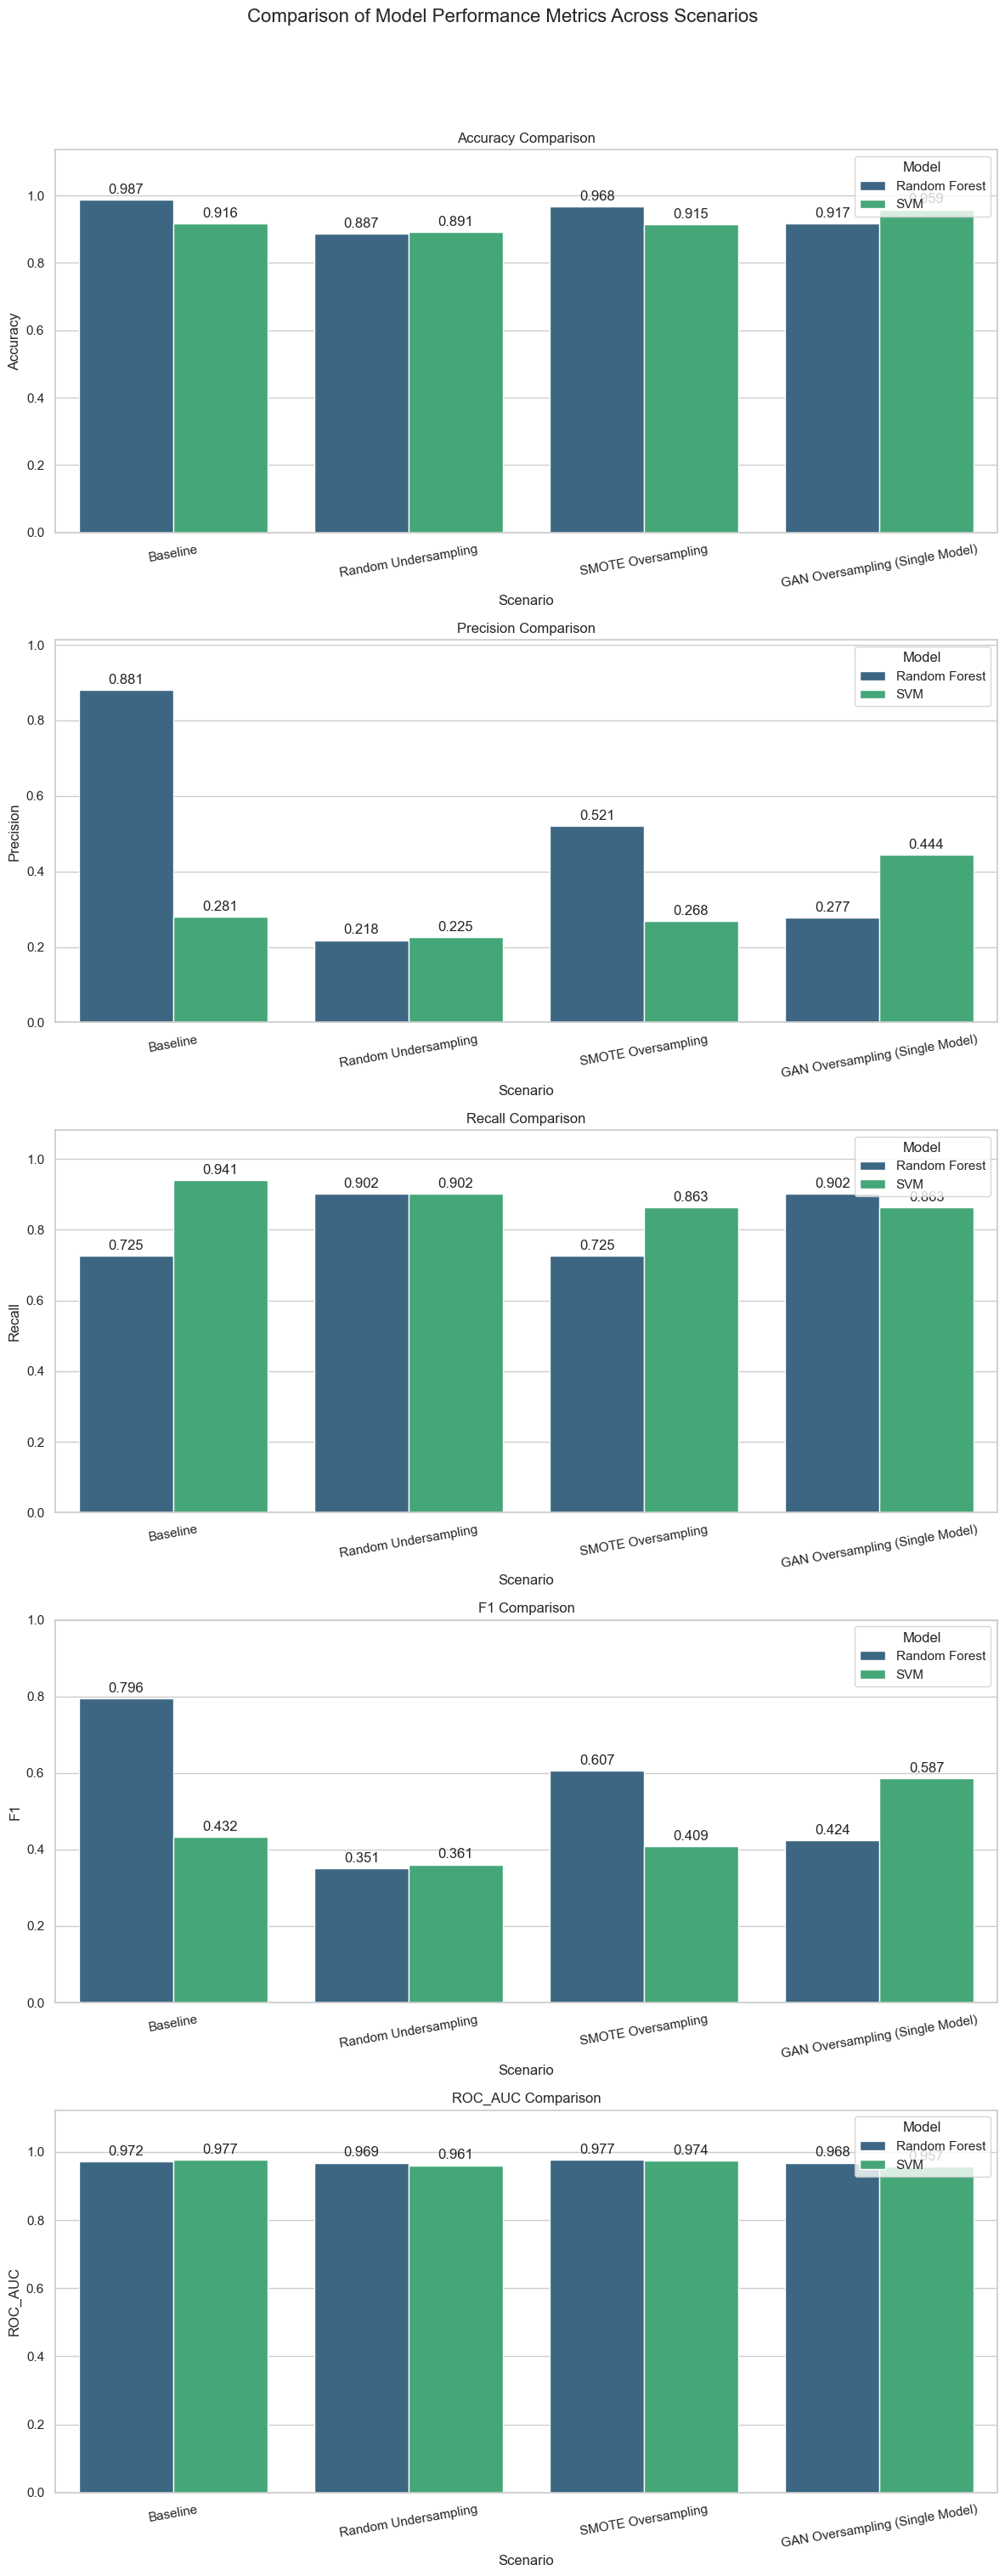

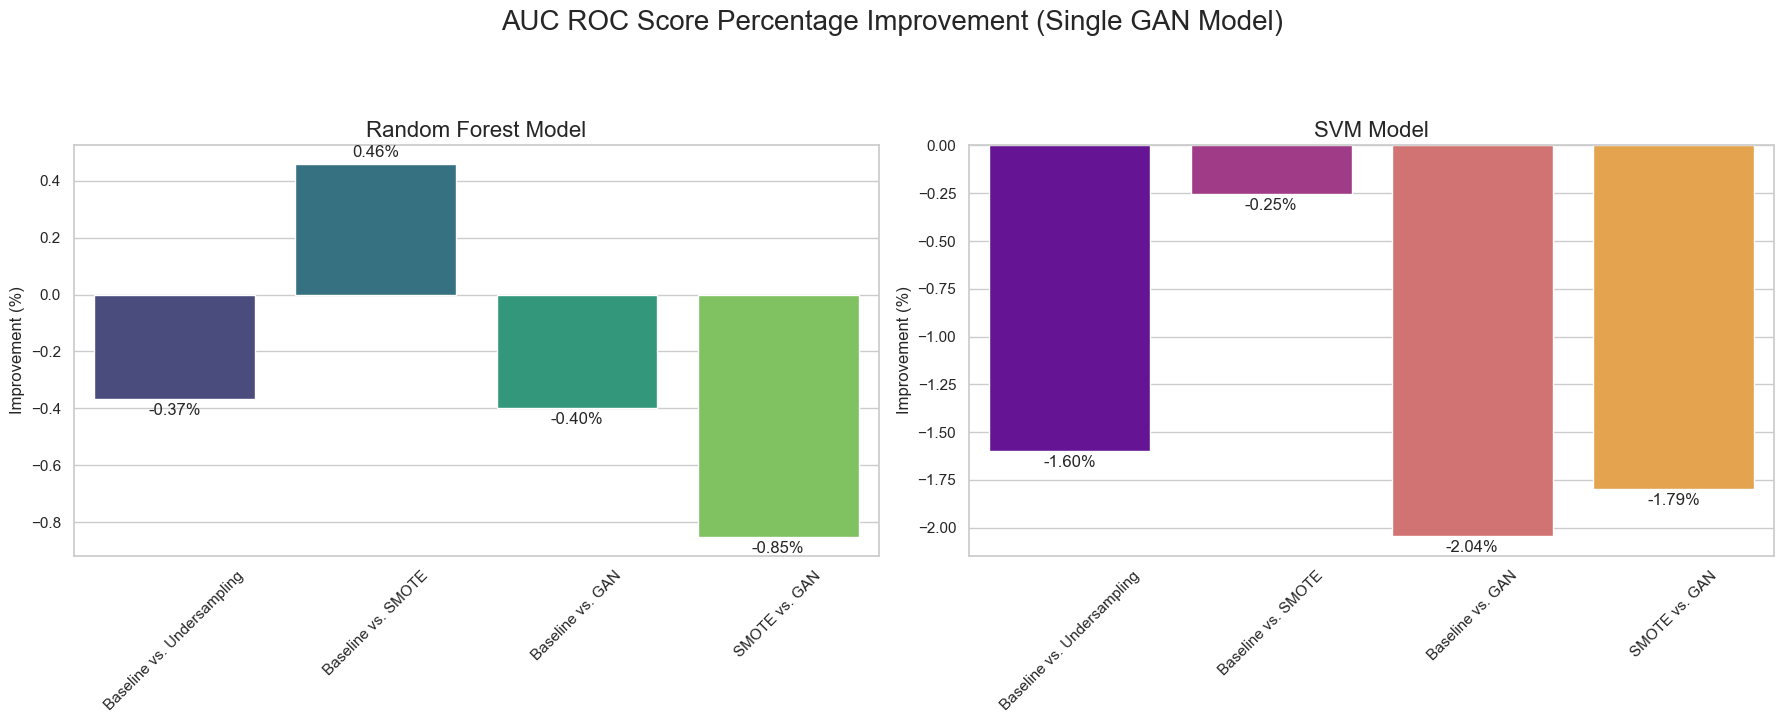

In [14]:
# Convert results dictionary to DataFrame
results_list = []
for scenario, models in results.items():
    for model, metrics in models.items():
        # Add scenario and model names to the metrics dictionary
        metrics['Scenario'] = scenario
        metrics['Model'] = model
        results_list.append(metrics)

if results_list:
    results_df = pd.DataFrame(results_list)
    # Reorder columns for clarity
    results_df = results_df[['Scenario', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']]
    
    # Format the DataFrame for better readability
    results_df_formatted = results_df.set_index(['Scenario', 'Model']).style.format("{:.4f}", na_rep="N/A").set_caption("Model Performance Metrics Across Scenarios")

    print("\n--- Comparative Results ---")
    display(results_df_formatted)

    # --- Visualization of Results ---
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 6 * len(metrics_to_plot)))
    fig.suptitle('Comparison of Model Performance Metrics Across Scenarios', fontsize=16, y=1.01)

    scenario_order = ['Baseline', 'Random Undersampling', 'SMOTE Oversampling', 'GAN Oversampling (Single Model)']
    
    for i, metric in enumerate(metrics_to_plot):
        sns.barplot(data=results_df, x='Scenario', y=metric, hue='Model', ax=axes[i], palette='viridis', order=scenario_order)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Scenario')
        axes[i].tick_params(axis='x', rotation=10)
        axes[i].legend(title='Model')
        # Add bar labels
        if not axes[i].patches:
            continue
        for container in axes[i].containers:
            axes[i].bar_label(container, fmt='%.3f', padding=3)
        axes[i].set_ylim(bottom=0, top=max(1.0, results_df[metric].max() * 1.15))

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    # Isolate the data for each model to make comparisons easier
    rf_results_df = results_df[results_df['Model'] == 'Random Forest'].set_index('Scenario')
    svm_results_df = results_df[results_df['Model'] == 'SVM'].set_index('Scenario')
    
    # --- Calculations for Random Forest ---
    # Get the baseline and SMOTE scores to compare against
    baseline_rf_auc = rf_results_df.loc['Baseline', 'ROC_AUC']
    smote_rf_auc = rf_results_df.loc['SMOTE Oversampling', 'ROC_AUC']
    gan_rf_auc = rf_results_df.loc['GAN Oversampling (Single Model)', 'ROC_AUC']
    
    # Calculate the percentage differences
    rf_diffs = {
        'Baseline vs. Undersampling': ((rf_results_df.loc['Random Undersampling', 'ROC_AUC'] - baseline_rf_auc) / baseline_rf_auc) * 100,
        'Baseline vs. SMOTE': ((smote_rf_auc - baseline_rf_auc) / baseline_rf_auc) * 100,
        'Baseline vs. GAN': ((gan_rf_auc - baseline_rf_auc) / baseline_rf_auc) * 100,
        'SMOTE vs. GAN': ((gan_rf_auc - smote_rf_auc) / smote_rf_auc) * 100
    }
    
    # --- Calculations for SVM ---
    # Get the baseline and SMOTE scores to compare against
    baseline_svm_auc = svm_results_df.loc['Baseline', 'ROC_AUC']
    smote_svm_auc = svm_results_df.loc['SMOTE Oversampling', 'ROC_AUC']
    # *** NOTE: Use the correct scenario name for the single GAN model ***
    gan_svm_auc = svm_results_df.loc['GAN Oversampling (Single Model)', 'ROC_AUC']
    
    # Calculate the percentage differences
    svm_diffs = {
        'Baseline vs. Undersampling': ((svm_results_df.loc['Random Undersampling', 'ROC_AUC'] - baseline_svm_auc) / baseline_svm_auc) * 100,
        'Baseline vs. SMOTE': ((smote_svm_auc - baseline_svm_auc) / baseline_svm_auc) * 100,
        'Baseline vs. GAN': ((gan_svm_auc - baseline_svm_auc) / baseline_svm_auc) * 100,
        'SMOTE vs. GAN': ((gan_svm_auc - smote_svm_auc) / smote_svm_auc) * 100
    }
    
    # Convert the difference dictionaries to DataFrames for easy plotting
    rf_diffs_df = pd.DataFrame(list(rf_diffs.items()), columns=['Comparison', 'Percentage Difference'])
    svm_diffs_df = pd.DataFrame(list(svm_diffs.items()), columns=['Comparison', 'Percentage Difference'])
    
    # --- Visualization of Percentage Differences ---
    # Create a new figure with two plots side-by-side
    fig_diff, axes_diff = plt.subplots(1, 2, figsize=(18, 7))
    fig_diff.suptitle('AUC ROC Score Percentage Improvement (Single GAN Model)', fontsize=20, y=1.03)
    
    # Bar chart for Random Forest differences
    sns.barplot(data=rf_diffs_df, x='Comparison', y='Percentage Difference', ax=axes_diff[0], palette='viridis')
    axes_diff[0].set_title('Random Forest Model', fontsize=16)
    axes_diff[0].set_ylabel('Improvement (%)')
    axes_diff[0].set_xlabel('')
    axes_diff[0].tick_params(axis='x', rotation=45)
    # Add percentage labels on top of the bars
    for container in axes_diff[0].containers:
        axes_diff[0].bar_label(container, fmt='%.2f%%', padding=3)
    
    # Bar chart for SVM differences
    sns.barplot(data=svm_diffs_df, x='Comparison', y='Percentage Difference', ax=axes_diff[1], palette='plasma')
    axes_diff[1].set_title('SVM Model', fontsize=16)
    axes_diff[1].set_ylabel('Improvement (%)')
    axes_diff[1].set_xlabel('')
    axes_diff[1].tick_params(axis='x', rotation=45)
    # Add percentage labels on top of the bars
    for container in axes_diff[1].containers:
        axes_diff[1].bar_label(container, fmt='%.2f%%', padding=3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.show()
else:
    print("No results were generated to display.")

## 9. Visualizing the Impact of Sampling Techniques

To visually demonstrate *why* the different sampling techniques produce varying results, we can use a dimensionality reduction technique called **t-SNE**. t-SNE projects the high-dimensional sensor data into a 2D space, allowing us to see the "shape" of the data and how it is altered by each sampling method.

The following plots show the training data that the classifiers are fed in each scenario. We are looking for two things:
1.  **Balance:** How well the minority (failure) class is represented relative to the majority class.
2.  **Fidelity:** Whether the generated synthetic data respects the original data's structure. Do new points appear in realistic locations?

- **Gray Dots (`.`):** Represent the majority class (No Failure).
- **Colored Markers (`+`):** Represent the original, real failure events, colored by their specific type.
- **Orange Dots (`.`):** Represent the new, synthetic failure samples generated by SMOTE or the GAN.

Preparing data for visualization...
Running t-SNE on all scenarios. This may take a few minutes...
Visualizing: Baseline
Visualizing: Random Undersampling
Visualizing: SMOTE
Visualizing: GAN Oversampling (Single Model)


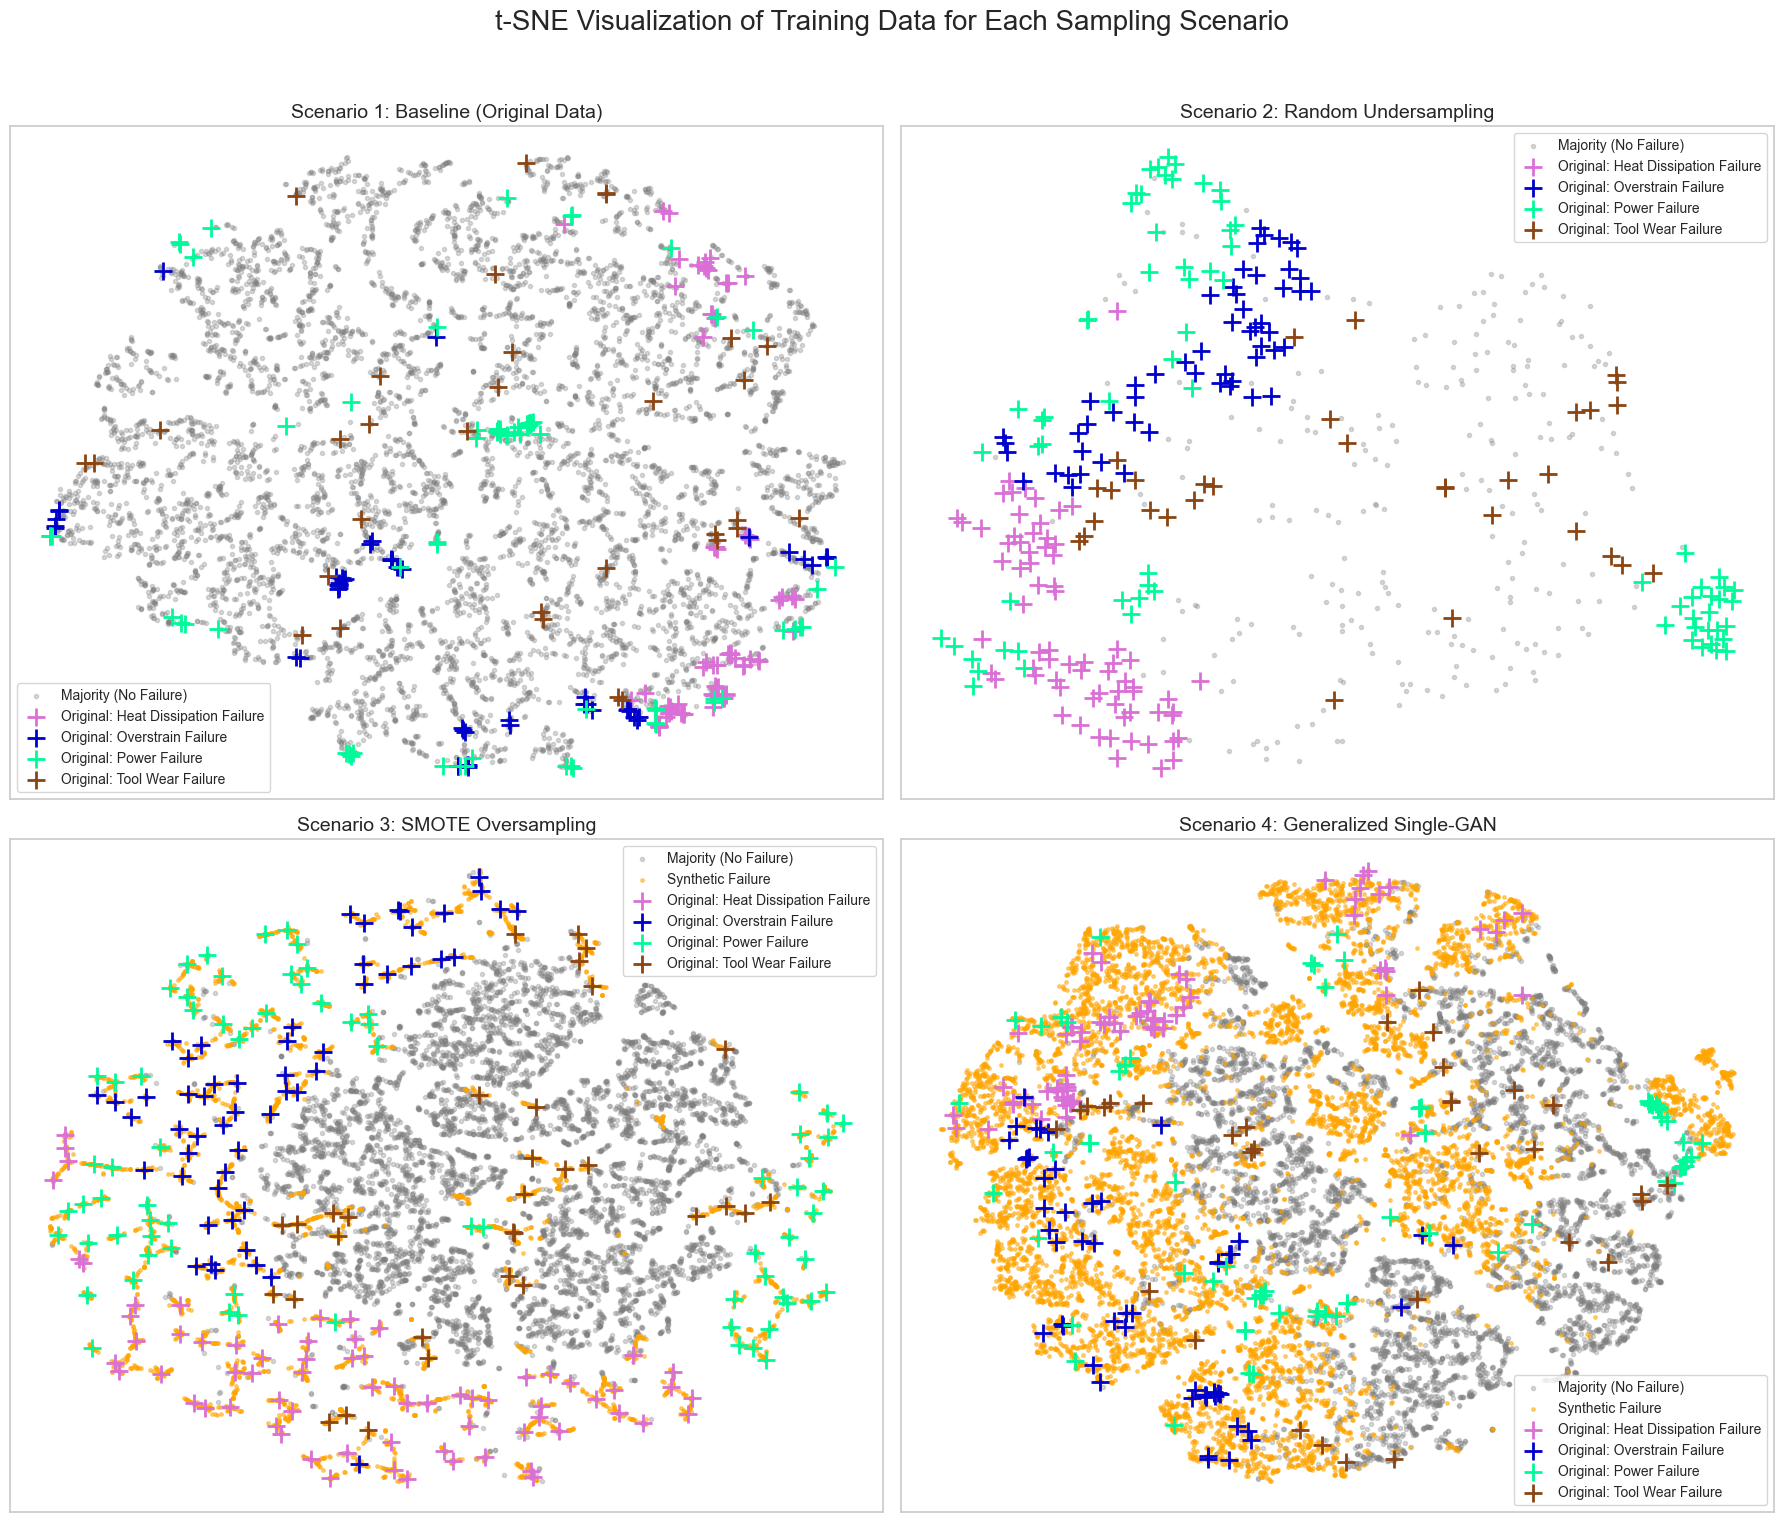

594

In [18]:
# --- Import necessary library for dimensionality reduction ---
from sklearn.manifold import TSNE
import gc # Garbage Collector

print("Preparing data for visualization...")

# --- 1. Data Preparation ---

# Use the same custom color map (colours come from CSS Color collection
failure_color_map = {
    'Heat Dissipation Failure': 'Orchid' # Orchid 
    ,
    'Overstrain Failure': 'MediumBlue' # MediumBlue
    ,
    'Power Failure': 'MediumSpringGreen' # MediumSpringGreen
    ,
    'Tool Wear Failure': 'SaddleBrown' # SaddleBrown 
}

# A. Preprocess the original training data (Baseline)
X_train_model_processed = preprocessor.fit_transform(X_train_model)

# B. Generate data for Random Undersampling (RUS)
rus_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
rus_sampler.fit_resample(X_train_model, y_train)
rus_indices = rus_sampler.sample_indices_
X_rus_resampled = X_train.iloc[rus_indices]
y_rus_resampled = y_train.iloc[rus_indices]
X_rus_resampled_processed = preprocessor.transform(X_rus_resampled.drop('FailureType', axis=1))
rus_failure_types_aligned = X_rus_resampled['FailureType']

# C. Generate data for SMOTE Oversampling
smote_sampler = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=-1)
X_smote_resampled_processed, y_smote_resampled = smote_sampler.fit_resample(X_train_model_processed, y_train)
num_original_samples = len(X_train_model_processed)

# D. Prepare GAN data (for the single-GAN model)
num_original_train = X_train_model.shape[0]
if 'X_train_gan_aug' in locals():
    X_train_gan_aug_processed = preprocessor.transform(X_train_gan_aug)
    X_gan_original_processed = X_train_gan_aug_processed[:num_original_train, :]
    X_gan_synthetic_processed = X_train_gan_aug_processed[num_original_train:, :]
else: # Handle case where GAN scenario was skipped
    X_train_gan_aug_processed, X_gan_original_processed, X_gan_synthetic_processed = None, None, None

# --- 2. t-SNE Visualization ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto', n_iter=500, n_jobs=-1)
print("Running t-SNE on all scenarios. This may take a few minutes...")

# Define the robust plotting function (with z-order and custom styling)
def plot_tsne(ax, X_tsne, y, title, failure_types_series, X_synthetic_tsne=None):
    y_mask_majority = (y == 0)
    y_mask_minority = (y == 1)

    ax.scatter(
        X_tsne[y_mask_majority, 0], X_tsne[y_mask_majority, 1],
        c='gray', marker='.', alpha=0.3, label='Majority (No Failure)', zorder=1
    )
    
    if X_synthetic_tsne is not None and X_synthetic_tsne.shape[0] > 0:
        ax.scatter(
            X_synthetic_tsne[:, 0], X_synthetic_tsne[:, 1],
            c='orange', marker='.', s=25, alpha=0.5,
            label='Synthetic Failure', zorder=2
        )

    minority_tsne = X_tsne[y_mask_minority]
    minority_failure_types = failure_types_series[y_mask_minority]

    for ft, color in failure_color_map.items():
        ft_mask = (minority_failure_types == ft).values
        if np.any(ft_mask):
            ax.scatter(
                minority_tsne[ft_mask, 0], minority_tsne[ft_mask, 1],
                c=color, marker='+', s=150, linewidth=2,
                label=f'Original: {ft}', zorder=3
            )
            
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='best', fontsize='small')

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('t-SNE Visualization of Training Data for Each Sampling Scenario', fontsize=20, y=0.95)
axes = axes.flatten()

# --- Plot 1: Baseline ---
print("Visualizing: Baseline")
X_baseline_tsne = tsne.fit_transform(X_train_model_processed)
plot_tsne(axes[0], X_baseline_tsne, y_train.values, 'Scenario 1: Baseline (Original Data)', X_train['FailureType'])

# --- Plot 2: Random Undersampling ---
print("Visualizing: Random Undersampling")
X_rus_tsne = tsne.fit_transform(X_rus_resampled_processed)
plot_tsne(axes[1], X_rus_tsne, y_rus_resampled.values, 'Scenario 2: Random Undersampling', rus_failure_types_aligned)

# --- Plot 3: SMOTE ---
print("Visualizing: SMOTE")
X_smote_tsne_full = tsne.fit_transform(X_smote_resampled_processed)
X_smote_original_tsne = X_smote_tsne_full[:num_original_samples, :]
X_smote_synthetic_tsne = X_smote_tsne_full[num_original_samples:, :]
plot_tsne(axes[2], X_smote_original_tsne, y_train.values, 'Scenario 3: SMOTE Oversampling', X_train['FailureType'], X_synthetic_tsne=X_smote_synthetic_tsne)

# --- Plot 4: GAN (Single Model) ---
print("Visualizing: GAN Oversampling (Single Model)")
# ** This title is updated for the single-GAN context **
gan_plot_title = 'Scenario 4: Generalized Single-GAN'
if X_train_gan_aug_processed is not None:
    X_gan_tsne_full = tsne.fit_transform(X_train_gan_aug_processed)
    X_gan_original_tsne = X_gan_tsne_full[:num_original_train, :]
    X_gan_synthetic_tsne = X_gan_tsne_full[num_original_train:, :]
    plot_tsne(axes[3], X_gan_original_tsne, y_train.values, gan_plot_title, X_train['FailureType'], X_synthetic_tsne=X_gan_synthetic_tsne)
else:
    axes[3].text(0.5, 0.5, "GAN Scenario Skipped", horizontalalignment='center', verticalalignment='center', fontsize=14)
    axes[3].set_title(gan_plot_title, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Clean up large objects from memory
del X_train_model_processed, X_rus_resampled_processed, X_smote_resampled_processed
if 'X_train_gan_aug_processed' in locals(): del X_train_gan_aug_processed
gc.collect()

## 10. Conclusion
